In [1]:
import trenchripper as tr

import csv
import copy
import ast
import h5py
import glob
import re
import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import pickle as pkl
import skimage as sk
import sklearn as skl

from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from Bio import SeqIO
from Bio.Seq import Seq

import goatools
import goatools.base
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib import pyplot as plt

dask_wd = "/home/de64/scratch/de64/dask"

plt.style.use('./deaton.mplstyle')

### Define Functions

In [2]:
def search_go(ns2assoc, obodag, inv_gene_to_id, go_term):
    namespace_abbv = {"biological_process":"BP","molecular_function":"MF","cellular_component":"CC"}
    
    print("Searching for " + str(obodag[go_term].name))
    namespace = namespace_abbv[obodag[go_term].namespace]
    child_goterms = list(obodag[go_term].get_all_children())
    gene_list = [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if go_term in val]
    for child_goterm in child_goterms:    
        gene_list += [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if child_goterm in val]
    gene_list = sorted(list(set(gene_list)))
    return gene_list

def label_positive_negative(x,ci_max_controls,ci_min_controls,pval=0.05):
    if (x["Value"]>ci_max_controls)&(x["Corrected P-Value"]<pval):
        return "Positive"
    elif (x["Value"]<ci_min_controls)&(x["Corrected P-Value"]<pval):
        return "Negative"
    else:
        return "Neither"
        
def lookup_variant(variant_library_path,channel,varid,trench_indices):
    path_prefix = variant_library_path + "/" + str(varid) + "_"
    variant_files = glob.glob(path_prefix + '*')
    n_files = len(variant_files)
    img_arr = []
    for i in range(n_files):
        variant_file = path_prefix + str(i) + ".hdf5"
        with h5py.File(variant_file,"r") as infile:
            data = infile[channel][trench_indices]
            img_arr.append(data)
    img_arr = np.concatenate(img_arr,axis=1)
    return img_arr
    
def make_volcano_plot(ss_estimator_df,param,param_label,highlighted_sgrna_list,highlighted_control,xrange,\
                      extra_highlight_category = None,\
                      control_categories = ['OnlyPlasmid', 'NoTarget'],sigma_vbars=3,figsize=(6,5),\
                     positive_color="tab:green",negative_color="tab:purple",noeffect_color="grey",\
                      control_color="tab:orange",extra_category_color="tab:blue",highlighted_outline_width=1,fontsize=18):
    ex_df = ss_estimator_df.loc[param]
    if extra_highlight_category != None:
        ex_df_highlighted_category = ex_df[ex_df[extra_highlight_category]]
        ex_df = ex_df[~ex_df[extra_highlight_category]]
        highlighted_sgrna_list_in_category = [sgrnaid for sgrnaid in highlighted_sgrna_list if sgrnaid in ex_df_highlighted_category.index.tolist()]
        highlighted_sgrna_list = [sgrnaid for sgrnaid in highlighted_sgrna_list if sgrnaid not in ex_df_highlighted_category.index.tolist()]
    
    ex_df_controls = ex_df[ex_df["Category"].isin(control_categories)]
    ex_df_nocontrols = ex_df[~ex_df["Category"].isin(control_categories)]
    ci_max_controls = np.mean(ex_df_controls["Value"]) + 3*np.std(ex_df_controls["Value"])
    ci_min_controls = np.mean(ex_df_controls["Value"]) - 3*np.std(ex_df_controls["Value"])
    ex_df_nocontrols["Volcano State"] = ex_df_nocontrols.apply(lambda x: label_positive_negative(x,ci_max_controls,ci_min_controls), axis=1)
    ex_df_highlighted = ex_df_nocontrols.loc[highlighted_sgrna_list]
    ex_df_controls_highlighted = ex_df_controls.loc[[highlighted_control]]

    max_log_FDR = np.max(ex_df[r"$-log_{10} FDR$"])

    fig,ax = plt.subplots(1,1,figsize=figsize)
    
    ci_max_controls = np.mean(ex_df_controls["Value"]) + sigma_vbars*np.std(ex_df_controls["Value"])
    ci_min_controls = np.mean(ex_df_controls["Value"]) - sigma_vbars*np.std(ex_df_controls["Value"])
    
    sns.scatterplot(data=ex_df_nocontrols[(ex_df_nocontrols["Volcano State"]=="Neither")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.03, color=noeffect_color,linewidth=0.5, s=80, zorder=-20)
    sns.scatterplot(data=ex_df_nocontrols[(ex_df_nocontrols["Volcano State"]=="Positive")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.2, color=positive_color,linewidth=0.5, s=80, zorder=-19)
    sns.scatterplot(data=ex_df_nocontrols[(ex_df_nocontrols["Volcano State"]=="Negative")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.2, color=negative_color,linewidth=0.5, s=80, zorder=-18)
    sns.scatterplot(data=ex_df_controls,x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.5, color=control_color,linewidth=0.5, s=80, zorder=-15)
    
    sns.scatterplot(data=ex_df_controls_highlighted,x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="black", alpha=1, color=control_color,linewidth=highlighted_outline_width, s=80, zorder=-14)
    sns.scatterplot(data=ex_df_highlighted[(ex_df_highlighted["Volcano State"]=="Positive")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="black", alpha=1, color=positive_color,linewidth=highlighted_outline_width, s=80, zorder=-15)
    sns.scatterplot(data=ex_df_highlighted[(ex_df_highlighted["Volcano State"]=="Negative")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="black", alpha=1, color=negative_color,linewidth=highlighted_outline_width, s=80, zorder=-14)

    if extra_highlight_category != None:
        ex_df_highlighted_category_nocontrols = ex_df_highlighted_category[~ex_df_highlighted_category["Category"].isin(control_categories)]
        ex_df_highlighted_category_highlighted = ex_df_highlighted_category_nocontrols.loc[highlighted_sgrna_list_in_category]
        sns.scatterplot(data=ex_df_highlighted_category_nocontrols,x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.5, color=extra_category_color,linewidth=0.5, s=80, zorder=-16)
        sns.scatterplot(data=ex_df_highlighted_category_highlighted,x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="black", alpha=1, color=extra_category_color,linewidth=highlighted_outline_width, s=80, zorder=-13)
        
    ax.set_yticks(ticks=[0,1,2,3,max_log_FDR],labels=["0","1","2","3",r"$\geq$" + "{:.2f}".format(max_log_FDR)],fontsize=fontsize-2,minor=False)
    ax.tick_params(axis='both', direction='out', labelsize=fontsize-2,  width=2, length=5)
    ax.tick_params(axis='both', direction='out', labelsize=fontsize-2,  width=1.5, which='minor', length=3)
    ax.set_xlabel(param_label,fontsize=fontsize)
    ax.set_ylabel(r"$-log_{10} FDR$",fontsize=fontsize)
    
    # Manually set the position of the y-axis label
    # The position is specified as (x, y) in axis coordinates (where 0 is the bottom, 1 is the top for y)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
    ax.vlines([ci_min_controls,ci_max_controls],-0.05,max_log_FDR+0.2,linestyle="--",color="black",linewidth=1.5)
    ax.hlines([-np.log10(0.05)],xrange[0],xrange[1],linestyle="--",color="black",linewidth=1.5)
    ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
    ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
    ax.set_ylim(0,max_log_FDR+0.2)
    ax.set_xlim(xrange[0],xrange[1])
    sns.despine(right=True,top=True)

    if extra_highlight_category != None:
        ex_df_highlighted = pd.concat([ex_df_highlighted,ex_df_highlighted_category_highlighted],axis=0)
        ex_df_highlighted = ex_df_highlighted.sort_values("Value")
        print(ex_df_highlighted["Gene"])
    return fig,ax,ex_df_highlighted

In [3]:
dask_controller = tr.trcluster.dask_controller(
    walltime="04:00:00",
    local=False,
    n_workers=20,
    n_workers_min=20,
    memory="16GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

230m
04:00:00


In [4]:
dask_controller.daskclient

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.120.16.229:8787/status,
Dashboard: http://10.120.16.229:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.120.16.229:42785,Workers: 0
Dashboard: http://10.120.16.229:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Figure 2A

In [7]:
### setup for nucleoid experiment
headpath = "/home/de64/scratch/de64/sync_folder/2023-01-14_lDE20_Run_9/Growth_Division/"

kymo_df = dd.read_parquet(headpath + "kymograph/metadata",calculate_divisions=True)
kymo_df = kymo_df.get_partition(0).compute()
kymo_df = kymo_df.reset_index().groupby("trench").first()

#### Kymograph with masks

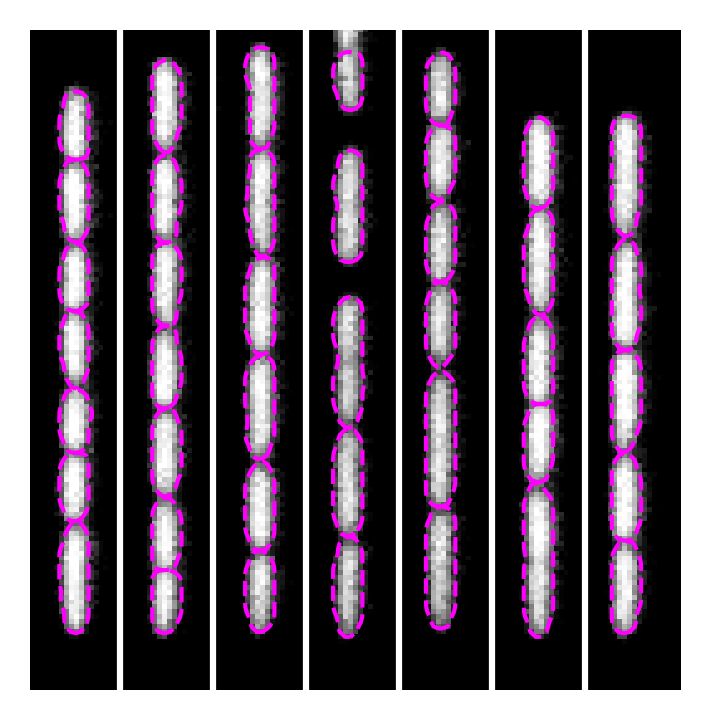

In [36]:
# fetch trenches
idx = 76
t_step = 1
# t_step = 1
t_i = 4
t_f = 11
# t_i = 36
cropx = 1

min_intensity = 900
max_intensity = 2500

magenta_weight = 1.
green_weight = 0.
# green_weight = 0.5

scalebar_on = False
output_path = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_2"

# selected_trench = barcode_df.iloc[idx]
selected_trench = kymo_df.iloc[idx]

file_idx,trench_idx,orient = selected_trench['File Index'],selected_trench['File Trench Index'],\
    selected_trench["lane orientation"]

with h5py.File(headpath + "/kymograph/kymograph_" +\
               str(file_idx) + ".hdf5", "r") as infile:
    data = infile["mCherry"][trench_idx,t_i:t_f:t_step,:,cropx:-cropx]
with h5py.File(headpath + "/fluorsegmentation/segmentation_" +\
               str(file_idx) + ".hdf5", "r") as infile:
    seg_data = infile["data"][trench_idx,t_i:t_f:t_step,:,cropx:-cropx]
if orient == "top":
    data = data[:,::-1]
    seg_data = seg_data[:,::-1]

cyto_output = np.concatenate([data[t] for t in range(data.shape[0])],axis=1)

seg_output = []
for t in range(seg_data.shape[0]):
    working_seg_data = seg_data[t]
    working_seg_data[working_seg_data>0] = working_seg_data[working_seg_data>0]+(100*t)
    seg_output.append(working_seg_data)
    
seg_output = np.concatenate(seg_output,axis=1)
seg_output, _, _ = sk.segmentation.relabel_sequential(seg_output)

seg_borders_list = []
for i in range(1,np.max(seg_output)+1):
    seg_borders = sk.measure.find_contours(sk.filters.gaussian(seg_output == i,sigma=1), level=0.5)[0]
    seg_borders_list.append(seg_borders)

# merged_image = get_magenta_green_overlay(cyto_output,cyto_output,min_intensity_green,max_intensity_green,\
#                                        min_intensity_magenta,max_intensity_magenta,mag_weight=magenta_weight,\
#                                         green_weight=green_weight)

# # # np.clip(img_green.astype(np.uint32) + img_magenta.astype(np.uint32), 0, 65535).astype(np.uint16)
plt.imshow(cyto_output,cmap="Greys_r",vmin=min_intensity,vmax=max_intensity)
for i,seg_border in enumerate(seg_borders_list):
    plt.plot(seg_border[:,1],seg_border[:,0],color="magenta",linestyle="--",linewidth=1)
plt.ylim(140,5)
# Add a label next to the scale bar
if scalebar_on:
    # Draw the scale bar
    plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
            [scalebar_y_position, scalebar_y_position],
            color=scalebar_color,
            linewidth=6)
    plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
            scalebar_y_position+5,
            f'{scale_bar_size_um} $\mu m$',
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=25)
plt.vlines([(seg_data.shape[2]*t)-1 for t in range(1,seg_data.shape[0])],0,seg_data.shape[1],linestyle="-",color="white",linewidth=1.5,zorder=20)
plt.axis('off')
plt.savefig(output_path + "/kymo_" + str(idx) + ".png",transparent=True,dpi=500,bbox_inches="tight")

#### Zoom in on cell mask (Length, Width, Intensity)

(-0.5, 132.5, 68.0, 38.0)

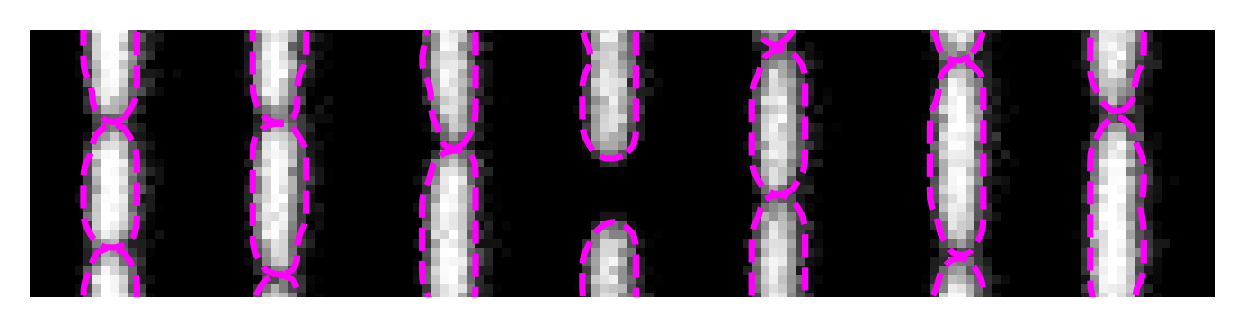

In [31]:
plt.imshow(cyto_output,cmap="Greys_r",vmin=min_intensity,vmax=max_intensity)
for i,seg_border in enumerate(seg_borders_list):
    plt.plot(seg_border[:,1],seg_border[:,0],color="magenta",linestyle="--",linewidth=1.5)
plt.ylim(68,38)
# plt.xlim(88,118)

# plt.vlines([seg_data.shape[2]*t for t in range(1,seg_data.shape[0])],38,68,linestyle="-",color="white",linewidth=1.5,zorder=20)
plt.axis('off')
# plt.savefig(output_path + "/kymo_" + str(idx) + "_zoom_1.png",transparent=True,dpi=500,bbox_inches="tight")

#### Zoom in on kymograph subset

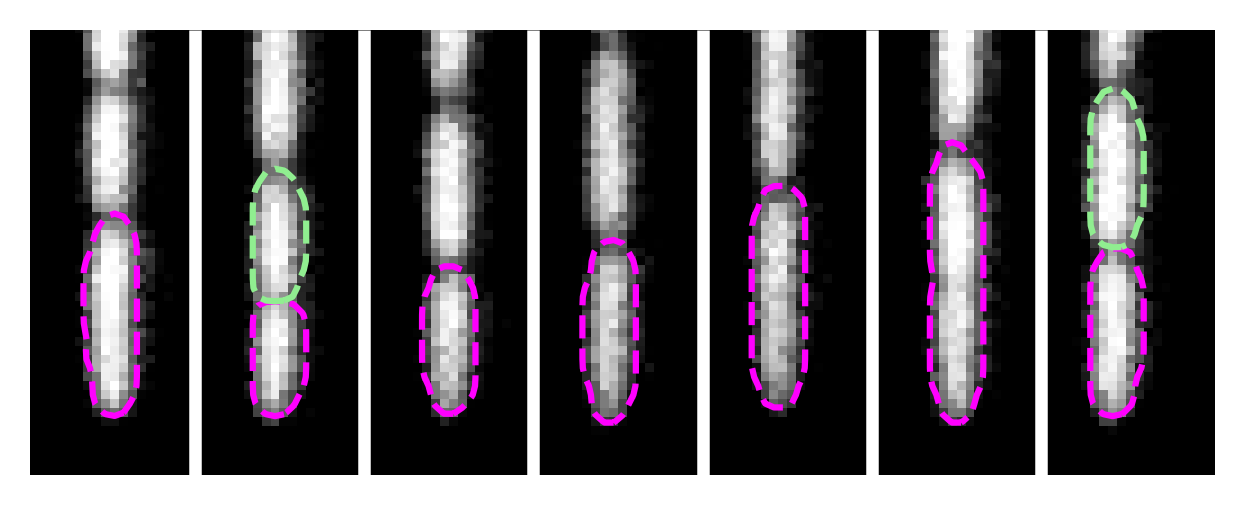

In [38]:
mother_cells = [np.max(seg_output[:,data.shape[2]*t:data.shape[2]*(t+1)]) for t in range(data.shape[0])]
mother_borders_list = []
for mother_idx in mother_cells:
    seg_borders = sk.measure.find_contours(sk.filters.gaussian(seg_output == mother_idx,sigma=1), level=0.5)[0]
    mother_borders_list.append(seg_borders)

sister_cells_list = [mother_cells[1]-1,mother_cells[-1]-1]
sister_borders_list = []
for sister_idx in sister_cells_list:
    seg_borders = sk.measure.find_contours(sk.filters.gaussian(seg_output == sister_idx,sigma=1), level=0.5)[0]
    sister_borders_list.append(seg_borders)

plt.imshow(cyto_output,cmap="Greys_r",vmin=min_intensity,vmax=max_intensity)
for i,seg_border in enumerate(mother_borders_list):
    plt.plot(seg_border[:,1],seg_border[:,0],color="magenta",linestyle="--",linewidth=1.5)
for i,seg_border in enumerate(sister_borders_list):
    plt.plot(seg_border[:,1],seg_border[:,0],color="lightgreen",linestyle="--",linewidth=1.5)
plt.ylim(135,85)

plt.vlines([(seg_data.shape[2]*t)-1 for t in range(1,seg_data.shape[0])],85,135,linestyle="-",color="white",linewidth=3,zorder=20)
plt.axis('off')
plt.savefig(output_path + "/kymo_" + str(idx) + "_zoom_2.png",transparent=True,dpi=500,bbox_inches="tight")

#### Length Plot

In [22]:
pheno_df = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2023-01-14_lDE20_Run_9_FOV_and_Time_Normalization",calculate_divisions=True)
pheno_df = pheno_df.get_partition(0).compute()
selected_pheno_df = pheno_df[pheno_df["trenchid"] == selected_trench["trenchid"]]
mother_pheno_df = selected_pheno_df[selected_pheno_df["Mother"]]

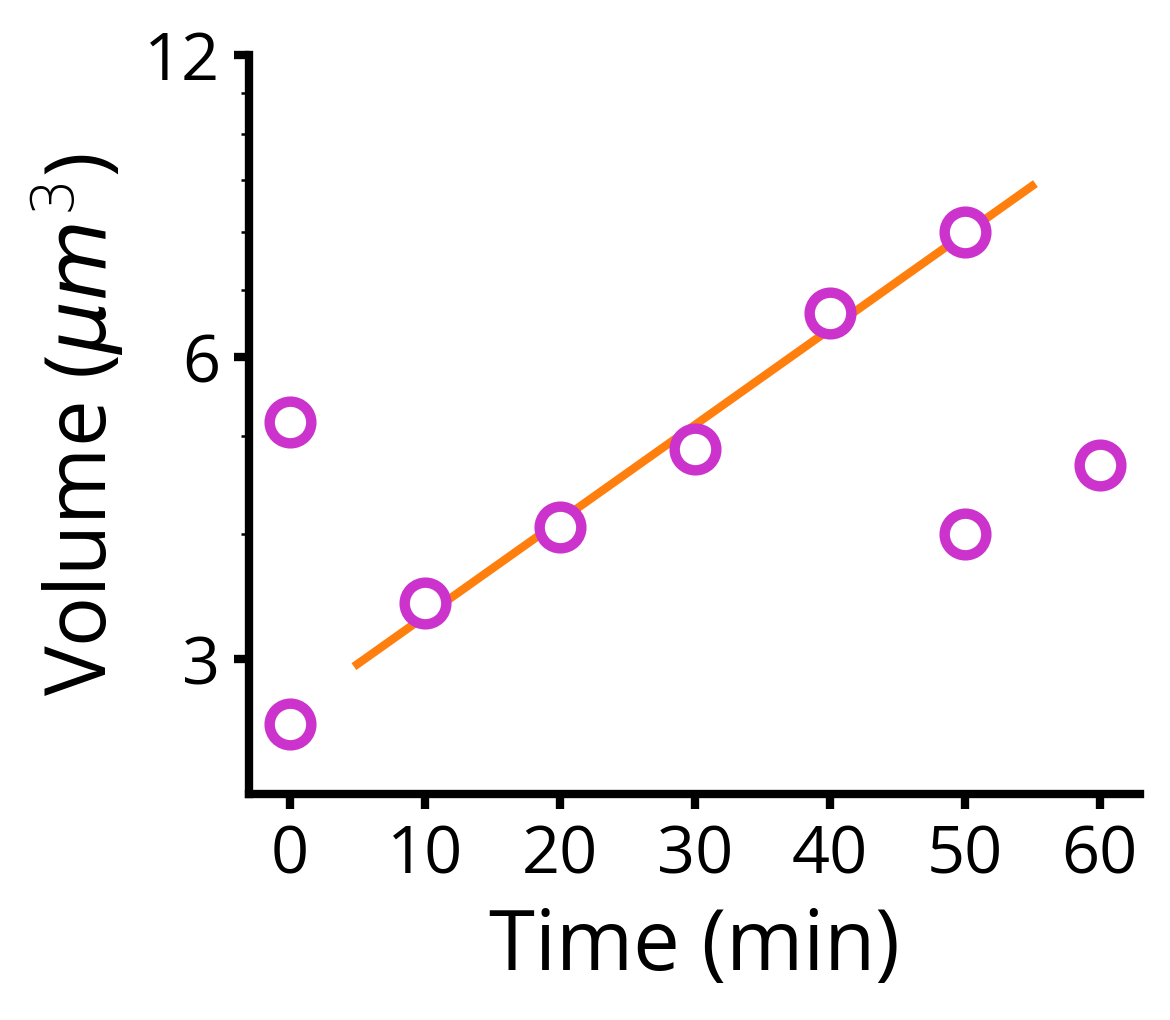

In [29]:
fig = plt.figure(figsize=(4,3.5))

linreg_time = np.linspace(5,55)

vol_arr = mother_pheno_df[t_i:t_f]["Volume"].values
time_arr = np.array(range(0,t_f-t_i))*10

linreg = skl.linear_model.LinearRegression().fit(time_arr[1:6][:,np.newaxis],np.log(vol_arr[1:6]))
linreg_output = np.exp(linreg.predict(linreg_time[:,np.newaxis]))

plt.scatter(time_arr,vol_arr,s=100,\
            facecolors='white', edgecolors='#CC33CC', linewidth=2.5,zorder=2)

# projected_div_time_1 = 5
# sister_1_vol = selected_pheno_df[selected_pheno_df["Global CellID"] == mother_pheno_df["Sister CellID"][t_i:t_f].iloc[1]].iloc[0]["Volume"]
# projected_div_size_1 = ((sister_1_vol+vol_arr[1])*vol_arr[0])**(1/2)
# sister_2_vol = selected_pheno_df[selected_pheno_df["Global CellID"] == mother_pheno_df["Sister CellID"][t_i:t_f].iloc[6]].iloc[0]["Volume"]

plt.scatter([0,50],[vol_arr[0]/2,vol_arr[5]/2],s=100,\
            facecolors='white', edgecolors='#CC33CC', linewidth=2.5,zorder=1)
# plt.vlines([0,50],[vol_arr[0]/2,vol_arr[5]/2],[vol_arr[0],vol_arr[5]],zorder=-1,linestyle="--",linewidth=2,color="black")

plt.plot(linreg_time,linreg_output,color="tab:orange",zorder=-2,linewidth=2)

plt.yscale("log")
plt.yticks([3,6,12],labels=["3","6","12"],fontsize=16)
plt.yticks([4,5,7,8,9,10,11],labels=[],minor=True)
plt.ylim(2.2,12)
plt.xticks(fontsize=16)

plt.ylabel(r"Volume ($ \mu m^{3} $)",fontsize=20)
plt.xlabel("Time (min)",fontsize=20)

ax = plt.gca()  # Get the current axes instance
ax.spines['bottom'].set_linewidth(2) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2)   # Set thickness of the left spine
ax.tick_params(axis='both', which='major', width=2)  # Set major tick width

sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig(output_path + "/kymo_" + str(idx) + "_growth_plot.png",transparent=True,dpi=500,bbox_inches="tight")

## Figure 2B

In [872]:
ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
lDE20_design = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Sequencing/2021-04-20_Essential_KO_Lib_df_coords_corrected.tsv",sep="\t")
cell_cycle_df = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2023-01-18_lDE20_Lineage_Cell_Cycle_Merged/", engine="pyarrow",calculate_divisions=True)
final_output_df_barcodes = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2023-01-18_lDE20_Final_Barcodes_df_Merged",engine="pyarrow",calculate_divisions=True)

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/dask/dataframe/io/parquet/core.py:1467: UserWarning: Length of partition statistics (37) does not match the partition count (549). This may indicate a bug or incorrect read_parquet usage. We must ignore the statistics and disable: filtering, divisions, and/or file aggregation.
  warnings.warn(


In [873]:
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]
final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[["Gene","Category"]]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df.reset_index().set_index("oDEPool7_id")

##hack to get both observations and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
ss_estimators_df = ss_estimators_df.join(observation_df,on='oDEPool7_id')
ss_estimators_df = ss_estimators_df.join(final_column_df)

n_obs_barcodes = ss_estimators_df.groupby("oDEPool7_id",sort=False)["N Observations"].sum().astype(int)
lDE20_design_no_controls = lDE20_design[lDE20_design["Category"]=='Target']
n_obs_barcodes_df = lDE20_design_no_controls[["oDEPool7_id","Gene"]].set_index("oDEPool7_id")
n_obs_barcodes_df["N Observations"] = n_obs_barcodes

cell_cycle_df_with_variant = cell_cycle_df[["Global CellID"]].join(final_output_df_barcodes[["oDEPool7_id"]].groupby("Multi-Experiment Phenotype Trenchid").first())
n_cell_cycles_barcode = cell_cycle_df_with_variant.groupby("oDEPool7_id").size().compute()
n_obs_barcodes_df["N Cell Cycles"] = n_cell_cycles_barcode

n_obs_barcodes_df.loc[np.isnan(n_obs_barcodes_df["N Observations"]),"N Observations"] = 0
n_obs_barcodes_df.loc[np.isnan(n_obs_barcodes_df["N Cell Cycles"]),"N Cell Cycles"] = 0

n_obs_genes = n_obs_barcodes_df.groupby("Gene",sort=False)["N Observations"].sum().astype(int)
n_obs_sgrna = n_obs_barcodes_df["N Observations"]
n_cell_cycles_genes = n_obs_barcodes_df.groupby("Gene")["N Cell Cycles"].apply(lambda x: np.nansum(x)).astype(int)
n_cell_cycles_sgrna = n_obs_barcodes_df["N Cell Cycles"]

### Sampling Rate

/tmp/ipykernel_17834/3132678633.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["","","",""])


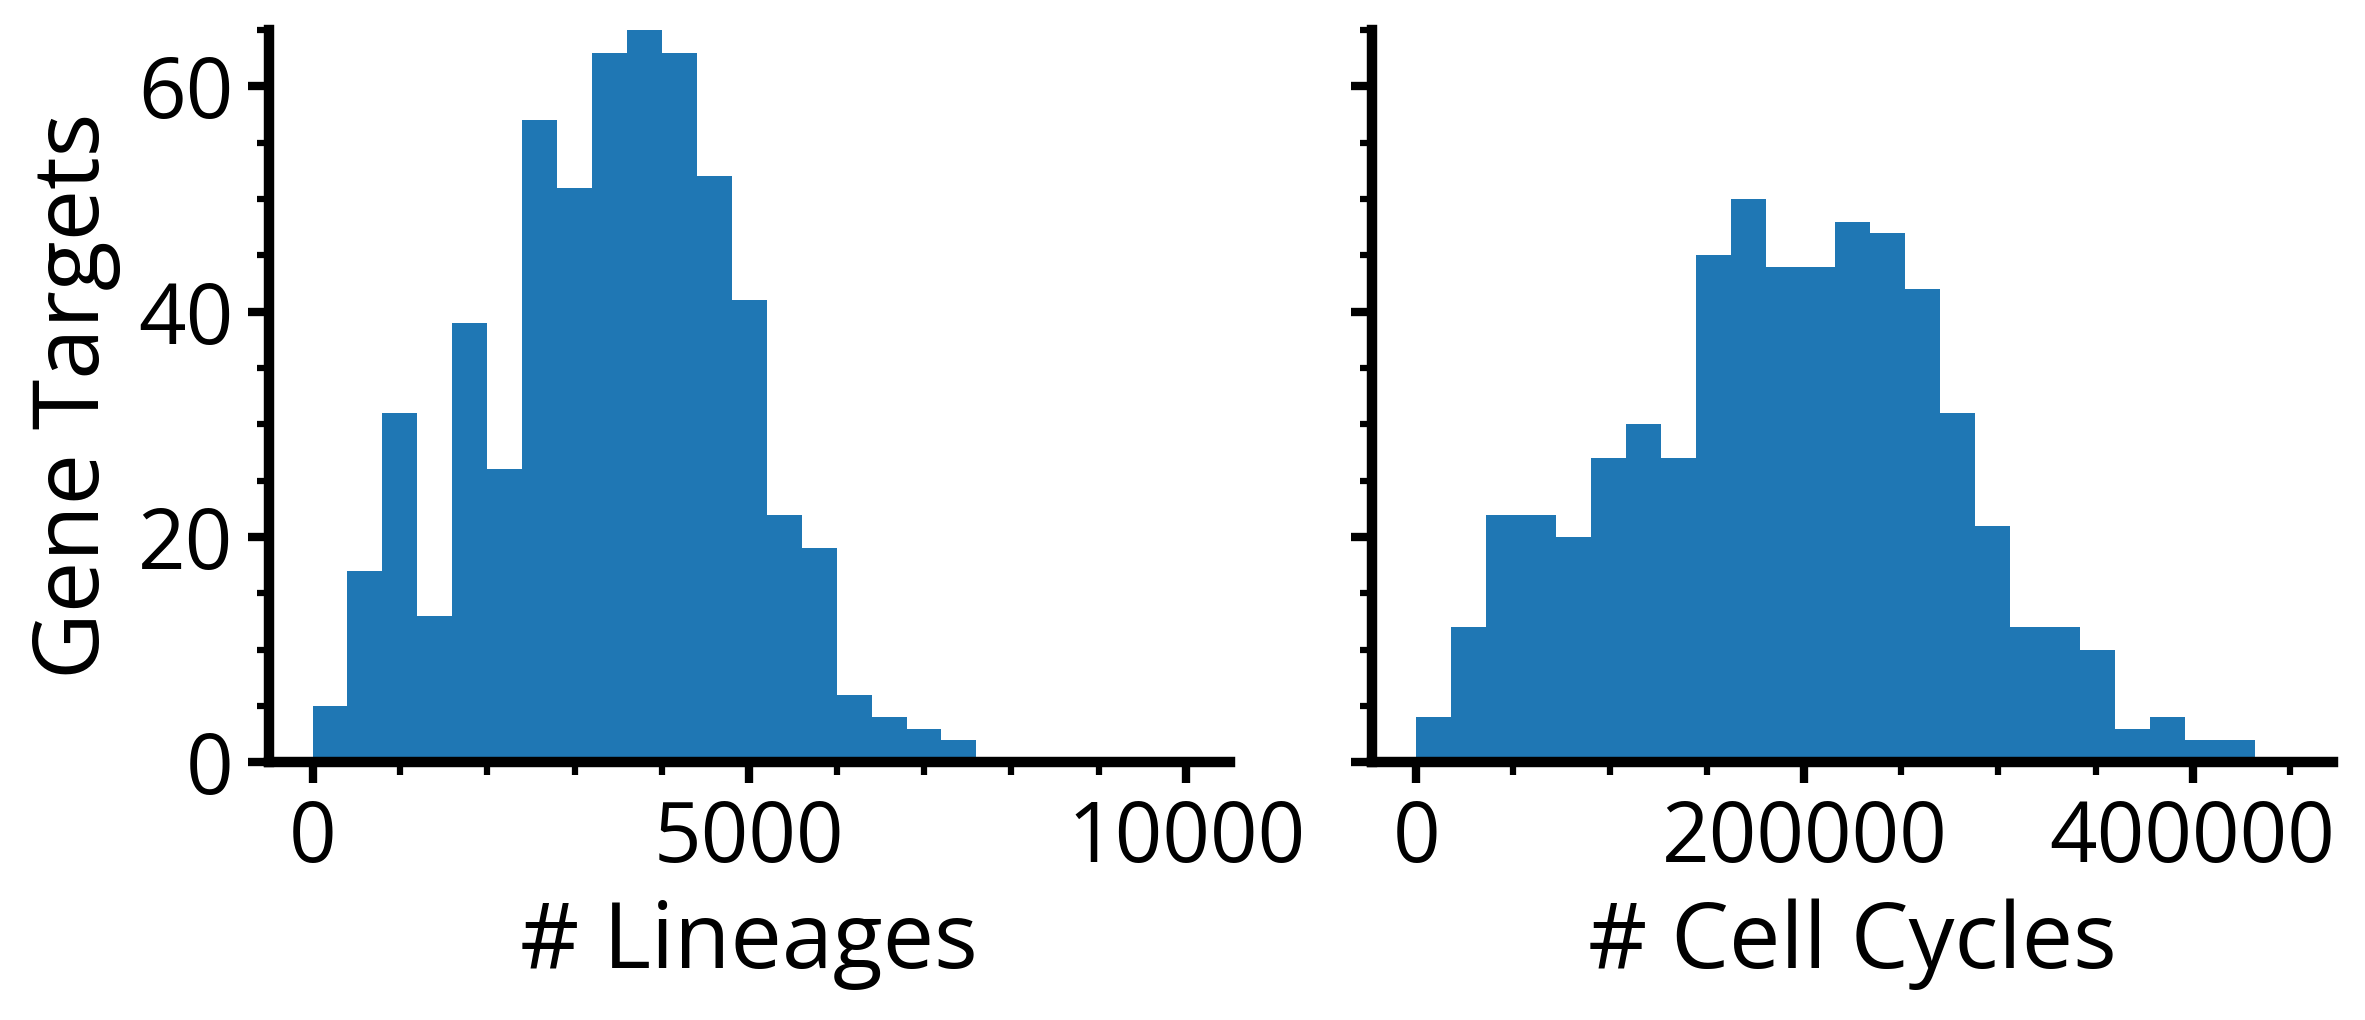

In [874]:
plt.figure(figsize=(8,3.5))

ax = plt.subplot(1,2,1)
ax.minorticks_on()
ax.set_xlabel("# Lineages",fontsize=22)
ax.set_ylabel("Gene Targets",fontsize=22)
ax.tick_params(axis='both', direction='out', labelsize=20,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=20,  width=1.5, which='minor', length=3)
ax.hist(n_obs_genes,range=(0,10000),bins=25)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine()
plt.ylim(0,65)

ax = plt.subplot(1,2,2)

ax.minorticks_on()
ax.set_xlabel("# Cell Cycles",fontsize=22)
ax.set_ylabel("",fontsize=22)
ax.tick_params(axis='both', direction='out', labelsize=20,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=20,  width=1.5, which='minor', length=3)
ax.hist(n_cell_cycles_genes,range=(0,450000),bins=25)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_yticklabels(["","","",""])

plt.subplots_adjust(wspace=0)

sns.despine()
plt.ylim(0,65)

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_2/lDE20_Variant_Coverage.png",transparent=True,dpi=500,bbox_inches="tight")

### Aggregation Procedure

In [75]:
pheT_sgrnaid = 9217
ftsN_sgrnaid = 9597
control_sgrnaid = 29659

sampling_rate = 10
kde_density = 250

steady_state_timepoints_df = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df",calculate_divisions=True)
steady_state_timepoints_df_selected = steady_state_timepoints_df[steady_state_timepoints_df["oDEPool7_id"].isin([pheT_sgrnaid,ftsN_sgrnaid,control_sgrnaid])].compute()
single_cell_dist = steady_state_timepoints_df_selected.groupby("oDEPool7_id").apply(lambda x: x["Length"].values)
length_trench_agg = steady_state_timepoints_df_selected.reset_index().groupby(["oDEPool7_id","Multi-Experiment Phenotype Trenchid"])["Length"].mean()

trench_bootstrap_df = steady_state_timepoints_df_selected.groupby("Multi-Experiment Phenotype Trenchid").apply(lambda x: tr.all_trench_bootstrap(x,tr.bootstrap_density,[[["Length"]]],return_kde=False,estimators=[np.nanmean],estimator_names=["Mean"],\
                         n_bootstraps_trench_density=1000,variant_index="oDEPool7_id",trench_index="Multi-Experiment Phenotype Trenchid",\
                         cell_index="Multi-Experiment Global CellID"))

pheT_trench_bootstrap_df = trench_bootstrap_df[trench_bootstrap_df["oDEPool7_id"]==pheT_sgrnaid]
ftsN_trench_bootstrap_df = trench_bootstrap_df[trench_bootstrap_df["oDEPool7_id"]==ftsN_sgrnaid]
control_trench_bootstrap_df = trench_bootstrap_df[trench_bootstrap_df["oDEPool7_id"]==control_sgrnaid]

pheT_trench_bootstrap_sampled_df = pheT_trench_bootstrap_df.groupby("Multi-Experiment Phenotype Trenchid").apply(lambda x: tr.get_trench_sample_df(x,1000,250000,["Length"],variant_index="oDEPool7_id"))
pheT_agg_arr = np.median(pheT_trench_bootstrap_sampled_df.to_xarray().to_array().values[0][:sampling_rate].astype(float), axis=0)[:,0]

ftsN_trench_bootstrap_sampled_df = ftsN_trench_bootstrap_df.groupby("Multi-Experiment Phenotype Trenchid").apply(lambda x: tr.get_trench_sample_df(x,1000,250000,["Length"],variant_index="oDEPool7_id"))
ftsN_agg_arr = np.median(ftsN_trench_bootstrap_sampled_df.to_xarray().to_array().values[0][:sampling_rate].astype(float), axis=0)[:,0]

control_trench_bootstrap_sampled_df = control_trench_bootstrap_df.groupby("Multi-Experiment Phenotype Trenchid").apply(lambda x: tr.get_trench_sample_df(x,1000,250000,["Length"],variant_index="oDEPool7_id"))
control_agg_arr = np.median(control_trench_bootstrap_sampled_df.to_xarray().to_array().values[0][:sampling_rate].astype(float), axis=0)[:,0]

/tmp/ipykernel_30357/3021880069.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  single_cell_dist = steady_state_timepoints_df_selected.groupby("oDEPool7_id").apply(lambda x: x["Length"].values)


In [76]:
log_domain = np.logspace(0, 4.5, num=kde_density, base=2)

pheT_cell_density = gaussian_kde(single_cell_dist[pheT_sgrnaid])(log_domain)
ftsN_cell_density = gaussian_kde(single_cell_dist[ftsN_sgrnaid])(log_domain)
control_cell_density = gaussian_kde(single_cell_dist[control_sgrnaid])(log_domain)

pheT_trench_density = gaussian_kde(pheT_trench_bootstrap_df["Value"])(log_domain)
ftsN_trench_density = gaussian_kde(ftsN_trench_bootstrap_df["Value"])(log_domain)
control_trench_density = gaussian_kde(control_trench_bootstrap_df["Value"])(log_domain)

pheT_median_density = gaussian_kde(pheT_agg_arr)(log_domain)
ftsN_median_density = gaussian_kde(ftsN_agg_arr)(log_domain)
control_median_density = gaussian_kde(control_agg_arr)(log_domain)

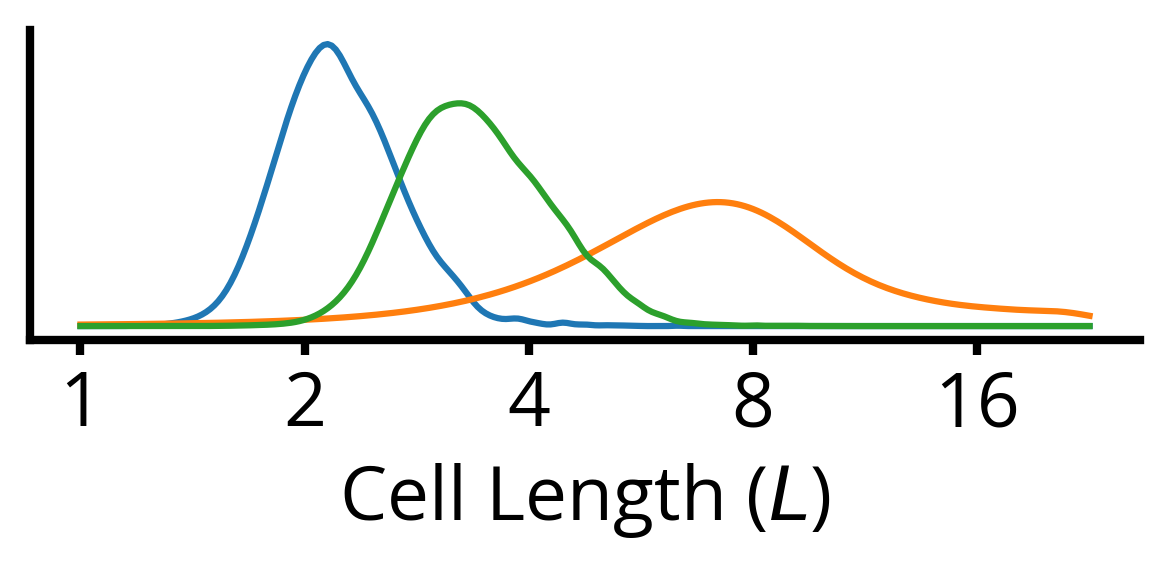

In [84]:
fig = plt.figure(figsize=(4,2))
ax = plt.subplot(1,1,1)

ax.plot(log_domain,pheT_cell_density/np.sum(pheT_cell_density),linewidth=1.5,color="tab:blue")
ax.plot(log_domain,ftsN_cell_density/np.sum(ftsN_cell_density),linewidth=1.5,color="tab:orange")
ax.plot(log_domain,control_cell_density/np.sum(control_cell_density),linewidth=1.5,color="tab:green")

ax.set_yticks([],labels=[])
# plt.yticks([4,5,7,8,9,10,11],labels=[],minor=True)
# plt.ylim(2.2,12)
# ax.set_xlabel(title,fontsize=20)
# plt.title(r"Cell Length ($L$)",fontsize=20)
plt.xlabel(r"Cell Length ($L$)",fontsize=18)

plt.xticks(fontsize=18)
plt.xscale("log",base=2)
ax.set_xticks([1,2,4,8,16],labels=["1","2","4","8","16"])
# plt.xlim(1,20)

ax.spines['bottom'].set_linewidth(2) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2)   # Set thickness of the left spine
ax.tick_params(axis='both', which='major', width=2)  # Set major tick width

sns.despine(right=True,top=True)

plt.tight_layout()
plt.savefig(output_path + "/cell_distribution_length.png",transparent=True,dpi=500,bbox_inches="tight")

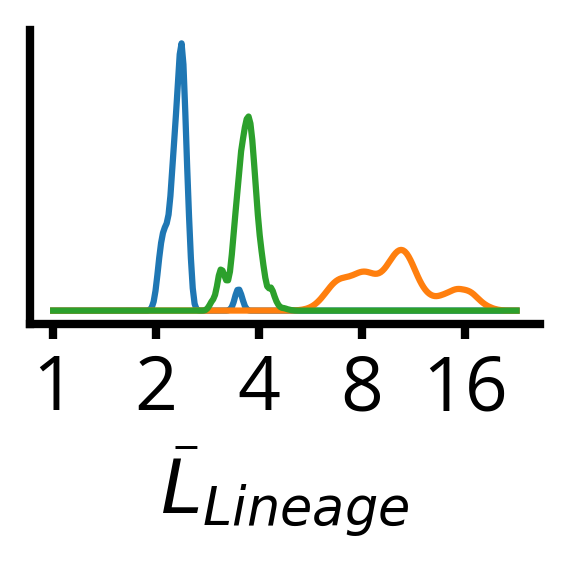

In [85]:
fig = plt.figure(figsize=(2,2))
ax = plt.subplot(1,1,1)

ax.plot(log_domain,pheT_trench_density/np.sum(pheT_trench_density),linewidth=1.5,color="tab:blue")
ax.plot(log_domain,ftsN_trench_density/np.sum(ftsN_trench_density),linewidth=1.5,color="tab:orange")
ax.plot(log_domain,control_trench_density/np.sum(control_trench_density),linewidth=1.5,color="tab:green")

ax.set_yticks([],labels=[])
# plt.yticks([4,5,7,8,9,10,11],labels=[],minor=True)
# plt.ylim(2.2,12)
# ax.set_xlabel(title,fontsize=20)
# plt.title(r"$\bar{L}_{Lineage}$",fontsize=20)
plt.xlabel(r"$\bar{L}_{Lineage}$",fontsize=18)

plt.xticks(fontsize=18)
plt.xscale("log",base=2)
ax.set_xticks([1,2,4,8,16],labels=["1","2","4","8","16"])
# plt.xlim(1,20)

ax.spines['bottom'].set_linewidth(2) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2)   # Set thickness of the left spine
ax.tick_params(axis='both', which='major', width=2)  # Set major tick width

sns.despine(right=True,top=True)

plt.tight_layout()
plt.savefig(output_path + "/trench_distribution_length.png",transparent=True,dpi=500,bbox_inches="tight")

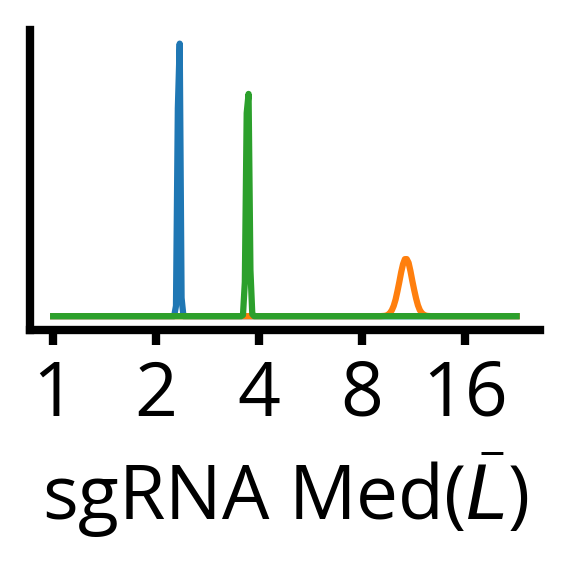

In [86]:
fig = plt.figure(figsize=(2,2))
ax = plt.subplot(1,1,1)

ax.plot(log_domain,pheT_median_density/np.sum(pheT_median_density),linewidth=1.5,color="tab:blue")
ax.plot(log_domain,ftsN_median_density/np.sum(ftsN_median_density),linewidth=1.5,color="tab:orange")
ax.plot(log_domain,control_median_density/np.sum(control_median_density),linewidth=1.5,color="tab:green")

ax.set_yticks([],labels=[])
# plt.yticks([4,5,7,8,9,10,11],labels=[],minor=True)
# plt.ylim(2.2,12)
# ax.set_xlabel(title,fontsize=20)
# plt.title(r"sgRNA Med($\bar{L}$)",fontsize=20)
plt.xlabel(r"sgRNA Med($\bar{L}$)",fontsize=18)

plt.xticks(fontsize=18)
plt.xscale("log",base=2)
ax.set_xticks([1,2,4,8,16],labels=["1","2","4","8","16"])
# plt.xlim(1,20)

ax.spines['bottom'].set_linewidth(2) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2)   # Set thickness of the left spine
ax.tick_params(axis='both', which='major', width=2)  # Set major tick width

sns.despine(right=True,top=True)

plt.tight_layout()
plt.savefig(output_path + "/median_trench_distribution_length.png",transparent=True,dpi=500,bbox_inches="tight")

## Figure 2C

In [552]:
control_df = ss_estimators_df[ss_estimators_df["Category"].isin(['OnlyPlasmid', 'NoTarget'])]
control_means = control_df[["Length","Width"]].mean()

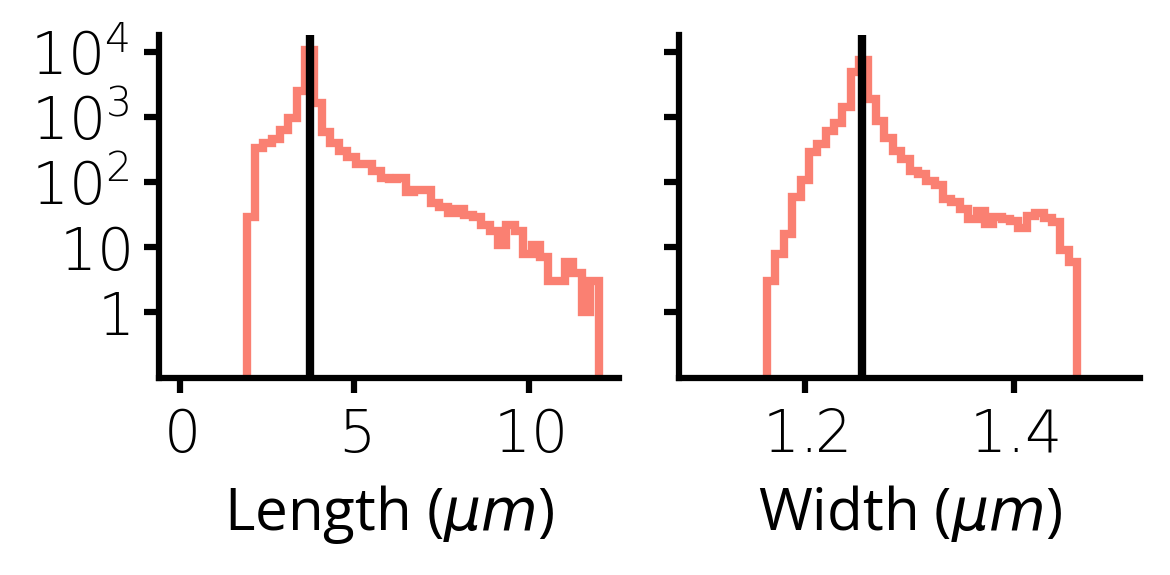

In [589]:
### Current Figure Version
nrows=1
ncols=2

fig = plt.figure(figsize=(4,2))

ax = plt.subplot(nrows,ncols,1)
plt.hist(ss_estimators_df['Length'],bins=50,histtype='step',range=(0,12),density=False,label="Postinduction",\
         log=True,color="salmon",linewidth=2)
ymin, ymax = plt.ylim(0.1,18000)
plt.vlines([control_means["Length"]],0,ymax,color="black",linewidth=2)
plt.xlabel("Length ($\mu m$)",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([1,10,100,1000,10000],["$1$","$10$",r"$10^{2}$",r"$10^{3}$",r"$10^{4}$"],fontsize=14)
plt.xticks([0,5,10],[r"$0$",r"$5$",r"$10$"],fontsize=14)

ax.spines['bottom'].set_linewidth(1.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(1.5)   # Set thickness of the left spine
ax.tick_params(axis='both', which='major', width=1.5)  # Set major tick width

# plt.legend()

ax = plt.subplot(nrows,ncols,2)
plt.hist(ss_estimators_df['Width'],bins=50,histtype='step',range=(1.1,1.5),density=False,label="Postinduction",\
         log=True,color="salmon",linewidth=2)
ymin, ymax = plt.ylim(0.1,18000)
plt.vlines([control_means["Width"]],0,ymax,color="black",linewidth=2)
plt.xlabel("Width ($\mu m$)",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([1,10,100,1000,10000],[r"",r"",r"",r"",r""],fontsize=14)
plt.xticks([1.2,1.4],[r"$1.2$",r"$1.4$"],fontsize=14)

sns.despine(right=True,top=True)

ax.spines['bottom'].set_linewidth(1.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(1.5)   # Set thickness of the left spine
ax.tick_params(axis='both', which='major', width=1.5)  # Set major tick width

plt.tight_layout()
plt.savefig(output_path + '/Property_Distributions.png',transparent=True, pad_inches="tight")

In [786]:
variant_library_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/Variant_Library"

#style for kymographs
vmin = 300
vmax = 6000
t_step = 3
t_i = 0
t_f = 60
channel="mCherry"

scale_bar_size_um = 10
scale_bar_thickness = 4
scalebar_color = 'black'  # Color of the scale bar
scalebar_y_position = -8 # Y-position of the scale bar in data units
scalebar_x_position = 35  # X-position of the scale bar in data units
pixel_microns = 0.2125 # Number of microns per pixel for this experiment (can also find in metadata.hdf5)
scale_bar_size_pixels = scale_bar_size_um//pixel_microns
scalebar_on = True

#### Short Cell

In [710]:
selected_variant_idx = 22
length_thr = 2.2

selected_short_variants = ss_estimators_df[ss_estimators_df["Length"]<length_thr]
print(selected_short_variants["Gene"].iloc[selected_variant_idx])
selected_short_variant_id = selected_short_variants.index[selected_variant_idx]

cysS


#### Long Cell

In [680]:
selected_variant_idx = 60
length_thr = 8

selected_long_variants = ss_estimators_df[ss_estimators_df["Length"]>length_thr]
print(selected_long_variants["Gene"].iloc[selected_variant_idx])
selected_long_variant_id = selected_long_variants.index[selected_variant_idx]

ftsW


#### Wide Cell

In [723]:
selected_variant_idx = 0
width_thr = 1.43

selected_wide_variants = ss_estimators_df[ss_estimators_df["Width"]>width_thr]
print(selected_wide_variants["Gene"].iloc[selected_variant_idx])
selected_wide_variant_id = selected_wide_variants.index[selected_variant_idx]

mreC


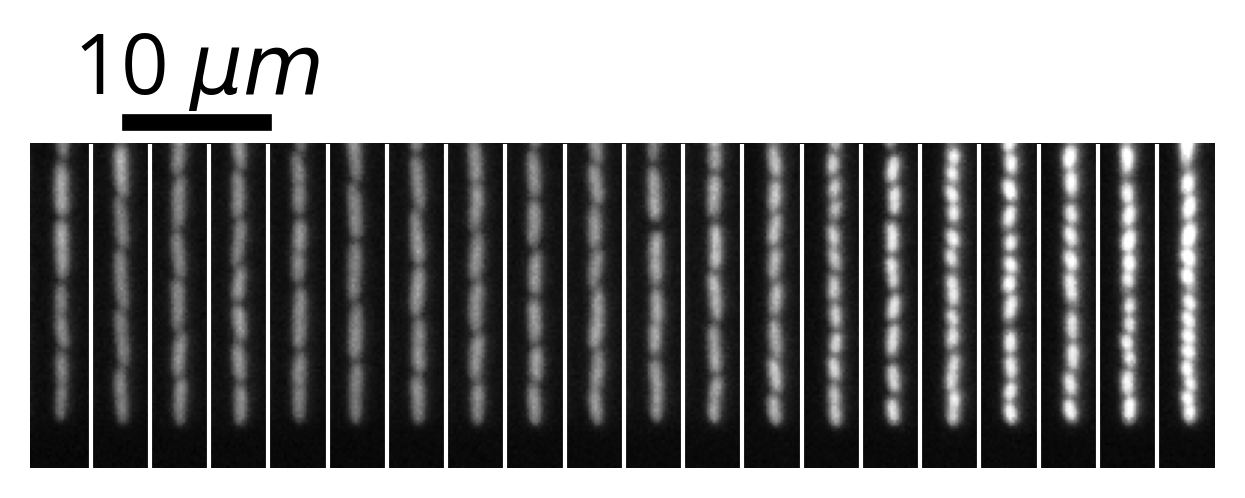

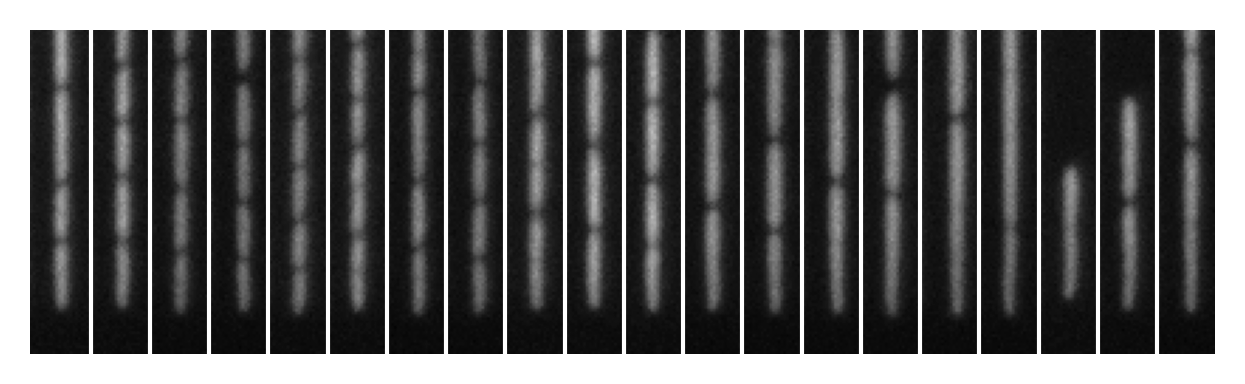

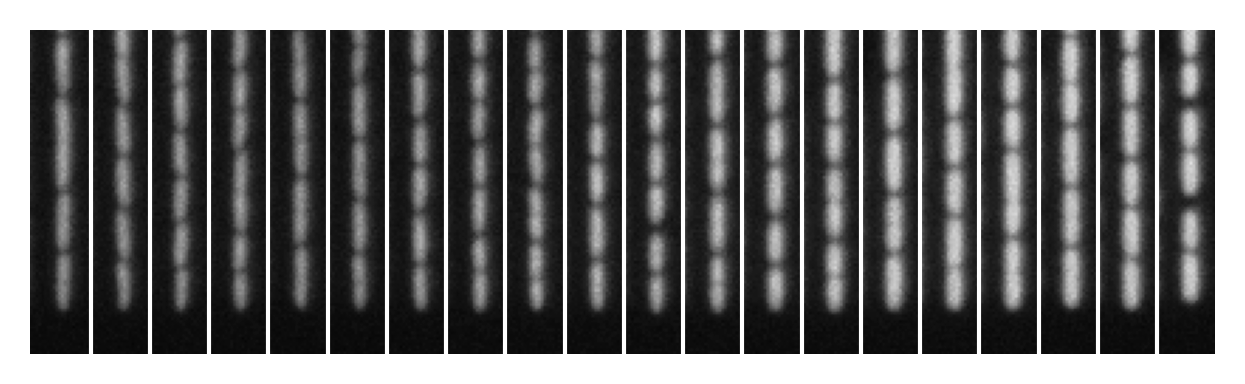

In [789]:
file_names = ["short_cell_kymo.png","long_cell_kymo.png","wide_cell_kymo.png"]
highlighted_df_sgrna_index = [selected_short_variant_id,selected_long_variant_id,selected_wide_variant_id]
highlighted_trenches_lists = [[0],[31],[1]]

# tr.writedir(base_export_path + "/Controls",overwrite=True)
for i in range(len(highlighted_df_sgrna_index)):
    highlighted_sgrna_idx = highlighted_df_sgrna_index[i]
    highlighted_trenches_list = highlighted_trenches_lists[i]
    
    variant_arr = lookup_variant(variant_library_path,channel,highlighted_df_sgrna_index[i],highlighted_trenches_list)
    variant_concat_arr = np.concatenate([variant_arr[i,:,30:145] for i in range(variant_arr.shape[0])], axis=1)
    gene_name = str(highlighted_df_sgrna_index[i])

    cropped_variant_arr = variant_concat_arr[:,::][t_i:t_f:t_step]
    tr.plot_kymograph(cropped_variant_arr,vmin=vmin,vmax=vmax)
    # plt.ylim(135,30)
    plt.axis('off')
    
    if scalebar_on and (i==0):
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-33,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
    plt.vlines([(cropped_variant_arr.shape[2]*t) for t in range(1,cropped_variant_arr.shape[0])],-0.5,114.5,linestyle="-",color="white",linewidth=1,zorder=20)
    plt.savefig(output_path + '/' + file_names[i], bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure 2D

In [534]:
# Get ontologies
obo_fname = download_go_basic_obo()

# Get ecoli association file (ecocyc)
gaf_handle = goatools.base.http_get("http://current.geneontology.org/annotations/ecocyc.gaf.gz",fout="./ecocyc.gaf.gz")
gaf_fname = goatools.base.gunzip("./ecocyc.gaf.gz")

## Getting ontologies and other nonesense

obodag = GODag(obo_fname)
objanno = GafReader(gaf_fname)
ns2assoc = objanno.get_ns2assc()

gene_to_id = {assoc.DB_Symbol:assoc.DB_ID for assoc in objanno.associations}
inv_gene_to_id = {assoc.DB_ID:assoc.DB_Symbol for assoc in objanno.associations}
synonym_dict = {synonym:assoc.DB_ID for assoc in objanno.associations for synonym in assoc.DB_Synonym}
gene_to_id.update(synonym_dict)

divisome_genes = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:1990586")

  EXISTS: go-basic.obo
requests.get(http://current.geneontology.org/annotations/ecocyc.gaf.gz, stream=True)
  WROTE: ./ecocyc.gaf.gz

go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
HMS:0:00:01.929611  58,540 annotations READ: ./ecocyc.gaf 
Searching for divisome complex


In [875]:
variant_library_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/Variant_Library"
base_export_path = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_2"

min_n_obervations = 5

ss_estimator_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
ss_estimator_df = ss_estimator_df[ss_estimator_df.apply(lambda x: np.nanmin([x["N Observations"],x["N Observations Proliferating"]]), axis=1)>=min_n_obervations]
ss_estimator_df = ss_estimator_df.loc["Mean (Robust)"]
ss_estimator_df[r"$-log_{10} FDR$"] = -np.log10(ss_estimator_df["Corrected P-Value"])

#hack to fix units
time_df = ss_estimator_df.loc[["Delta time (s)"]]
time_df["Value"] = time_df["Value"]/3600
time_df["Estimator Variance"] = time_df["Estimator Variance"]/(3600**2)
time_df["CI Width"] = time_df["Estimator Variance"]/3600
time_df = time_df.rename(index={"Delta time (s)":"Delta time (hr)"})
ss_estimator_df = pd.concat([time_df,ss_estimator_df.loc[list(set(ss_estimator_df.index.get_level_values(0).unique())-set(["Delta time (s)"]))]], axis=0)

growth_df = ss_estimator_df.loc[["Instantaneous Growth Rate: Volume"]]
growth_df["Value"] = growth_df["Value"]/np.log(2)
growth_df["Estimator Variance"] = growth_df["Estimator Variance"]/(np.log(2)**2)
growth_df["CI Width"] = growth_df["Estimator Variance"]/np.log(2)
ss_estimator_df = pd.concat([growth_df,ss_estimator_df.loc[list(set(ss_estimator_df.index.get_level_values(0).unique())-set(["Instantaneous Growth Rate: Volume"]))]], axis=0)

sept_df = ss_estimator_df.loc[["Septum Displacement Length Normalized"]]
sept_df["Value"] = sept_df["Value"]*100
sept_df["Estimator Variance"] = sept_df["Estimator Variance"]*(100**2)
sept_df["CI Width"] = sept_df["Estimator Variance"]*100
ss_estimator_df = pd.concat([sept_df,ss_estimator_df.loc[list(set(ss_estimator_df.index.get_level_values(0).unique())-set(["Septum Displacement Length Normalized"]))]], axis=0)

var_to_gene_series = ss_estimator_df.reset_index().groupby("oDEPool7_id")["Gene"].first()

ss_estimator_df["Divisome"] = ss_estimator_df["Gene"].isin(divisome_genes)

In [878]:
#style for kymographs
vmin = 300
vmax = 6000
t_step = 1
t_i = 59
t_f = 60
channel="mCherry"

scale_bar_size_um = 10
scale_bar_thickness = 4
scalebar_color = 'white'  # Color of the scale bar
scalebar_y_position = 105 # Y-position of the scale bar in data units
scalebar_x_position = 70  # X-position of the scale bar in data units
pixel_microns = 0.2125 # Number of microns per pixel for this experiment (can also find in metadata.hdf5)
scale_bar_size_pixels = scale_bar_size_um//pixel_microns
scalebar_on = True

/tmp/ipykernel_17834/3476335413.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
/tmp/ipykernel_17834/3476335413.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])
/tmp/ipykernel_

oDEPool7_id
1808     alaS
16778    ftsZ
27394    ftsA
13111    ftsL
8889     dnaA
6687     ftsW
28207    folA
9597     ftsN
26644    thyA
6220     rplQ
Name: Gene, dtype: string


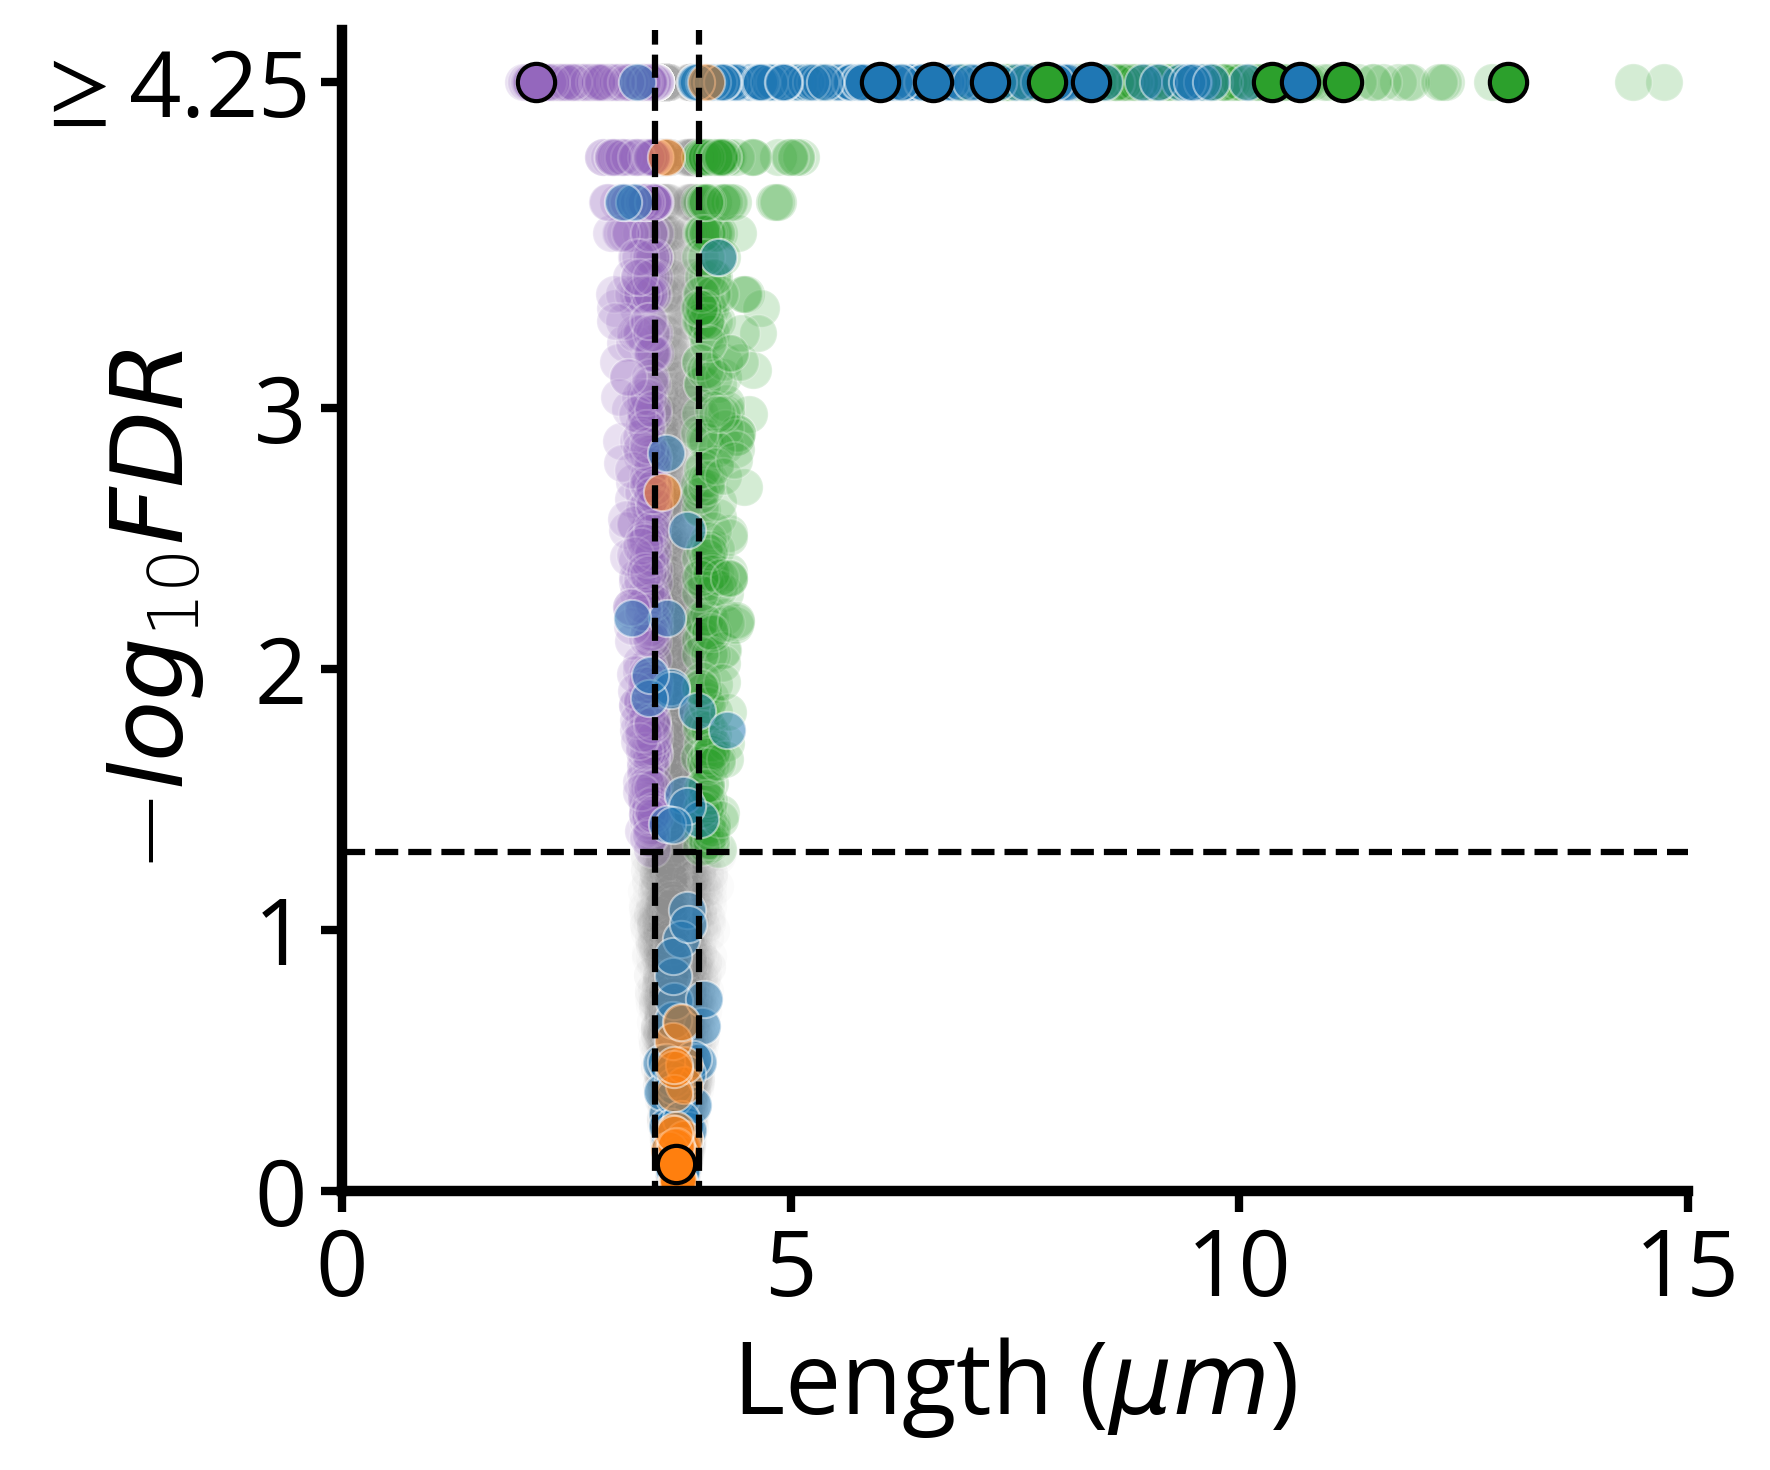

In [879]:
param = "Length"
param_label = "Length ($\mu m$)"

highlighted_sgrna_list = [1808,16778,27394,13111,6687,9597,26644,28207,6220,8889]
highlighted_control = 29662
xrange = (0,15)

ss_estimator_df_subset = ss_estimator_df.loc[param]
max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])

fig,ax,highlighted_df = make_volcano_plot(ss_estimator_df,param,param_label,highlighted_sgrna_list,highlighted_control,xrange,extra_highlight_category="Divisome",fontsize=24)
highlighted_df_sgrna_index = highlighted_df.index.tolist()
highlighted_gene_list = highlighted_df["Gene"].tolist()
plt.tight_layout()

plt.savefig(base_export_path + "/Length.png",transparent=True,dpi=500,bbox_inches="tight")

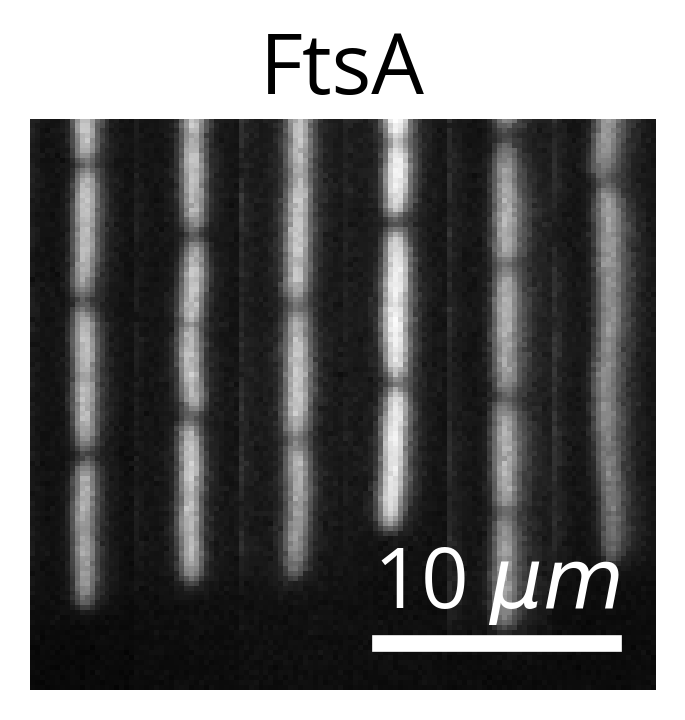

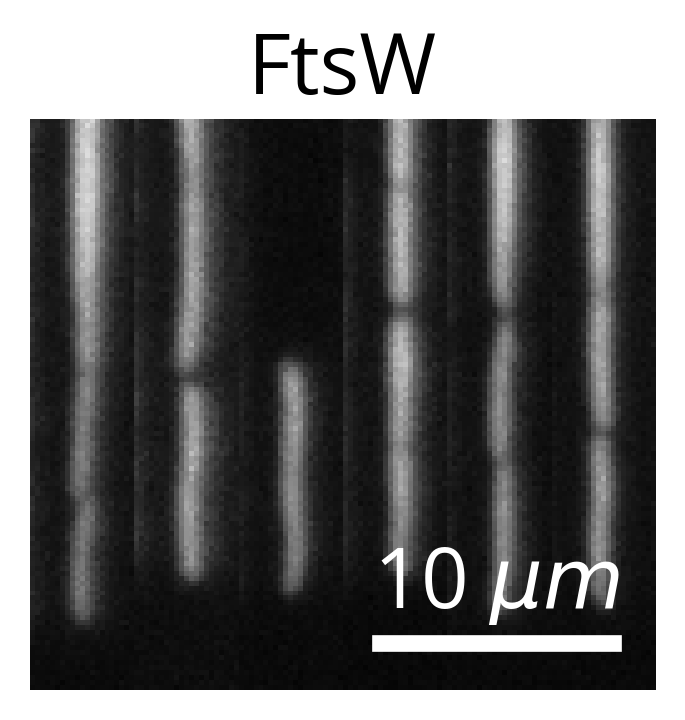

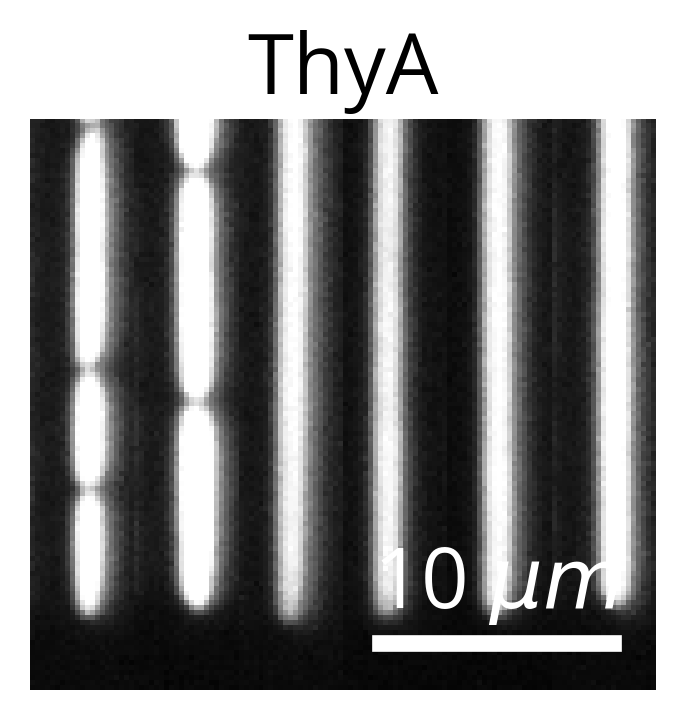

In [176]:
highlighted_sgrna_idx_list = [2,5,8]
highlighted_trenches_lists = [[2,5,6,8,9,11],[2,4,9,11,12,13],[0,2,6,7,8,9]]

tr.writedir(base_export_path + "/Length",overwrite=True)
for i in range(len(highlighted_sgrna_idx_list)):
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[i]
    highlighted_trenches_list = highlighted_trenches_lists[i]
    
    variant_arr = lookup_variant(variant_library_path,channel,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr = np.concatenate([variant_arr[i,:,30:145] for i in range(variant_arr.shape[0])], axis=2)
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]
    
    tr.plot_kymograph(variant_concat_arr[:,::][t_i:t_f:t_step],vmin=vmin,vmax=vmax)
    # plt.ylim(135,30)
    plt.axis('off')
    
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-20,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/Length/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure 2E

In [840]:
def create_colormap_function(vmin, vmax, cmap_name='viridis'):
    # Create a Normalize object which will map the data values from vmin to vmax
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # Get the colormap
    cmap = plt.cm.get_cmap(cmap_name)

    # Create a function that maps a value to a color
    def colormap_function(value):
        return cmap(norm(value))

    return colormap_function

In [841]:
sgRNA_timeseries_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Clustering/2023-01-23_sgRNA_Timeseries_df.pkl")
sgRNA_timeseries_df_controls = sgRNA_timeseries_df[sgRNA_timeseries_df["Category"].isin(['OnlyPlasmid', 'NoTarget'])]

ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]

lDE26_subset = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Sequencing/2023-02-03_Nucleoid_Screen_Design_V2.tsv",sep="\t")
lDE26_sgrnaids = lDE26_subset["oDEPool7_id"].tolist()

In [842]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Length','Width','Instantaneous Growth Rate: Volume']

min_n_observations = 8
sem_ratio_thr_ss = 0.2
sem_ratio_thr_timeseries = 0.2

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<sem_ratio_thr_ss]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

# ##removing controls
ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]

wt_width = np.median(ss_estimators_df_controls_only["Width"])
wt_length = np.median(ss_estimators_df_controls_only["Length"])
wt_gr = np.median(ss_estimators_df_controls_only["Instantaneous Growth Rate: Volume"])

In [843]:
## ftsN
ftsN_df = ss_estimators_df[ss_estimators_df["Gene"]=="ftsN"]
## dnaA
dnaA_df = ss_estimators_df[ss_estimators_df["Gene"]=="dnaA"]
## mreB
mreB_df = ss_estimators_df[ss_estimators_df["Gene"]=="mreB"]
## pheS
pheS_df = ss_estimators_df[ss_estimators_df["Gene"]=="pheS"]
## valS
valS_df = ss_estimators_df[ss_estimators_df["Gene"]=="valS"]
## dnaB
dnaB_df = ss_estimators_df[ss_estimators_df["Gene"]=="dnaB"]
## valS time
valS_time_df = sgRNA_timeseries_df[sgRNA_timeseries_df["Gene"]=="valS"]
valS_time_df = valS_time_df[["Kernel Trace: Length","Kernel Trace: Instantaneous Growth Rate: Volume",\
         "SEM: Kernel Trace: Length","SEM: Kernel Trace: Instantaneous Growth Rate: Volume",\
         "N Observations"]]
valS_time_df["Length SEM Ratio"] = valS_time_df["SEM: Kernel Trace: Length"]/valS_time_df["Kernel Trace: Length"]
valS_time_df["Growth SEM Ratio"] = valS_time_df["SEM: Kernel Trace: Instantaneous Growth Rate: Volume"]/valS_time_df["Kernel Trace: Instantaneous Growth Rate: Volume"]
valS_time_df = valS_time_df[(valS_time_df["N Observations"]>=min_n_observations)&\
valS_time_df["Length SEM Ratio"].apply(lambda x: np.all(x<sem_ratio_thr_timeseries))&\
valS_time_df["Growth SEM Ratio"].apply(lambda x: np.all(x<sem_ratio_thr_timeseries))]

ftsN_df_lDE26_subset = ftsN_df[ftsN_df.index.isin(lDE26_sgrnaids)]
dnaA_df_lDE26_subset = dnaA_df[dnaA_df.index.isin(lDE26_sgrnaids)]
mreB_df_lDE26_subset = mreB_df[mreB_df.index.isin(lDE26_sgrnaids)]
pheS_df_lDE26_subset = pheS_df[pheS_df.index.isin(lDE26_sgrnaids)]
valS_df_lDE26_subset = valS_df[valS_df.index.isin(lDE26_sgrnaids)]
dnaB_df_lDE26_subset = dnaB_df[dnaB_df.index.isin(lDE26_sgrnaids)]

/tmp/ipykernel_24954/2765740468.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)
/tmp/ipykernel_24954/2830085311.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(valS_df_subset["Kernel Trace: Instantaneous Growth Rate: Volume"].apply(lambda x: x[timepoint])/np.log(2),\


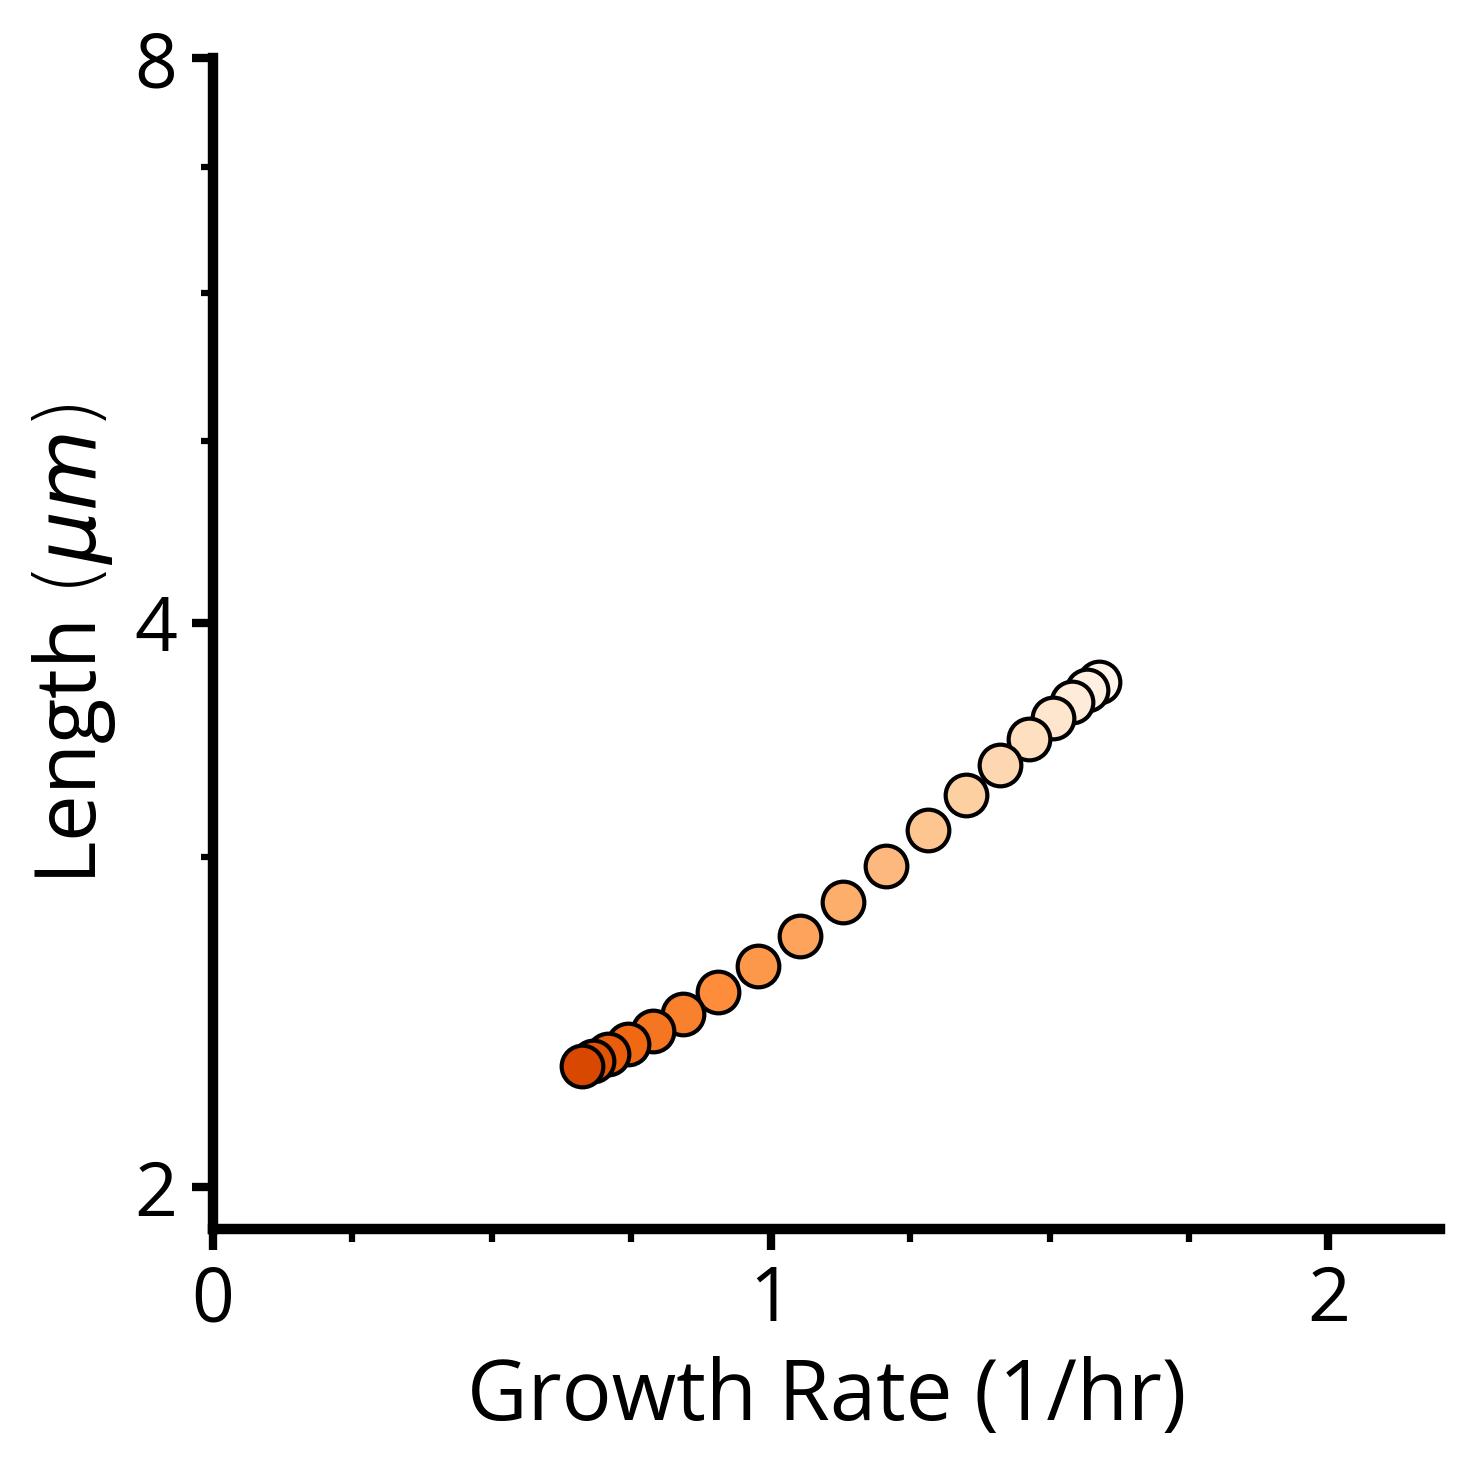

In [205]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

timepoints_list = list(range(0,19,1))
valS_df_sgrns_subset = [7035]
cmap_colors = ["Oranges","Greens","Blues","Purples"]
vmin, vmax = 0, 24


valS_df_subset = valS_time_df.loc[valS_df_sgrns_subset]

ax.set_title("",fontsize=20)
for j,sgrna in enumerate(valS_df_sgrns_subset):
    for i,timepoint in enumerate(timepoints_list):
        valS_df_subset = valS_time_df.loc[sgrna:sgrna] 
        cmap_color = cmap_colors[j]
        colormap_func = create_colormap_function(vmin, vmax,cmap_name=cmap_color)
        timepoint_color = colormap_func(timepoint)
        # ax.scatter(valS_df["Kernel Trace: Instantaneous Growth Rate: Volume"].apply(lambda x: x[timepoint])/np.log(2),\
        #             valS_df["Kernel Trace: Length"].apply(lambda x: x[timepoint]),alpha=1,s=50,c=timepoint_color)
        ax.scatter(valS_df_subset["Kernel Trace: Instantaneous Growth Rate: Volume"].apply(lambda x: x[timepoint])/np.log(2),\
                    valS_df_subset["Kernel Trace: Length"].apply(lambda x: x[timepoint]),edgecolors='black',alpha=1,s=100,c=timepoint_color)
# ax.scatter(wt_gr/np.log(2),wt_length,color="white",s=100,edgecolors='black',linewidth=2)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=20)
ax.set_ylabel("Length $ (\mu m) $",fontsize=20)
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,6)
ax.set_yscale("log")
ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],fontsize=18,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)
plt.savefig(base_export_path + "/ValS_Timepoint_Titration.png",transparent=True,dpi=500,bbox_inches="tight")

/tmp/ipykernel_17834/2765740468.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)
/tmp/ipykernel_17834/38672204.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(growth_rate,valS_df_subset["Kernel Trace: Length"].apply(lambda x: x[timepoint]),edgecolors='black',alpha=1,s=100,c=timepoint_color)


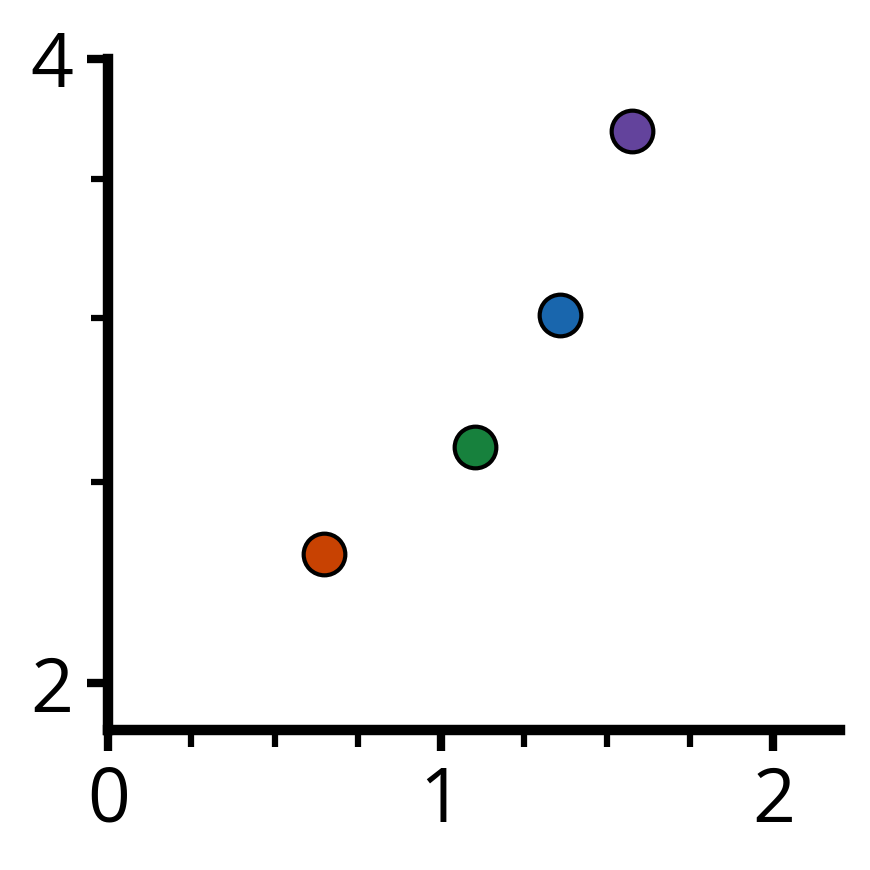

In [882]:
# Create figure
fig = plt.figure(figsize=(3, 3))
# Define GridSpec: 3 rows, 1 column
timepoints_list = [19]
valS_df_sgrns_subset = [7035,22378,22379,7059]
cmap_colors = ["Oranges","Greens","Blues","Purples"]
vmin, vmax = 0, 24
x_linspace = np.linspace(0,2.2,num=100)

ax = plt.subplot(1,1,1) # Spans first two rows, all columns

valS_df_subset = valS_time_df.loc[valS_df_sgrns_subset]

for j,sgrna in enumerate(valS_df_sgrns_subset):
    for i,timepoint in enumerate(timepoints_list):
        valS_df_subset = valS_time_df.loc[sgrna:sgrna] 
        cmap_color = cmap_colors[j]
        colormap_func = create_colormap_function(vmin, vmax,cmap_name=cmap_color)
        timepoint_color = colormap_func(timepoint)
        growth_rate = valS_df_subset["Kernel Trace: Instantaneous Growth Rate: Volume"].apply(lambda x: x[timepoint])/np.log(2)
        density_at_growth_rate = gaussian_kde(valS_time_df["Kernel Trace: Instantaneous Growth Rate: Volume"].apply(lambda x: x[-1])/np.log(2))(growth_rate.values)[0]
        ax.scatter(growth_rate,valS_df_subset["Kernel Trace: Length"].apply(lambda x: x[timepoint]),edgecolors='black',alpha=1,s=100,c=timepoint_color)
        axtop.scatter(growth_rate,density_at_growth_rate, zorder=10, color=timepoint_color, s=100, edgecolors='black')
        
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,4)
ax.set_yscale("log")
ax.set_yticks(ticks=[2,4],labels=["2","4"],fontsize=18,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[2.5,3,3.5],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=4)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig(base_export_path + "/ValS_Timepoint_Titration_Inset.png",transparent=True,dpi=500,bbox_inches="tight")

/tmp/ipykernel_24954/2765740468.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)
/tmp/ipykernel_24954/1140810555.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(timepoint,0,edgecolors='black',alpha=1,s=1000,linewidth=2,c=timepoint_color)


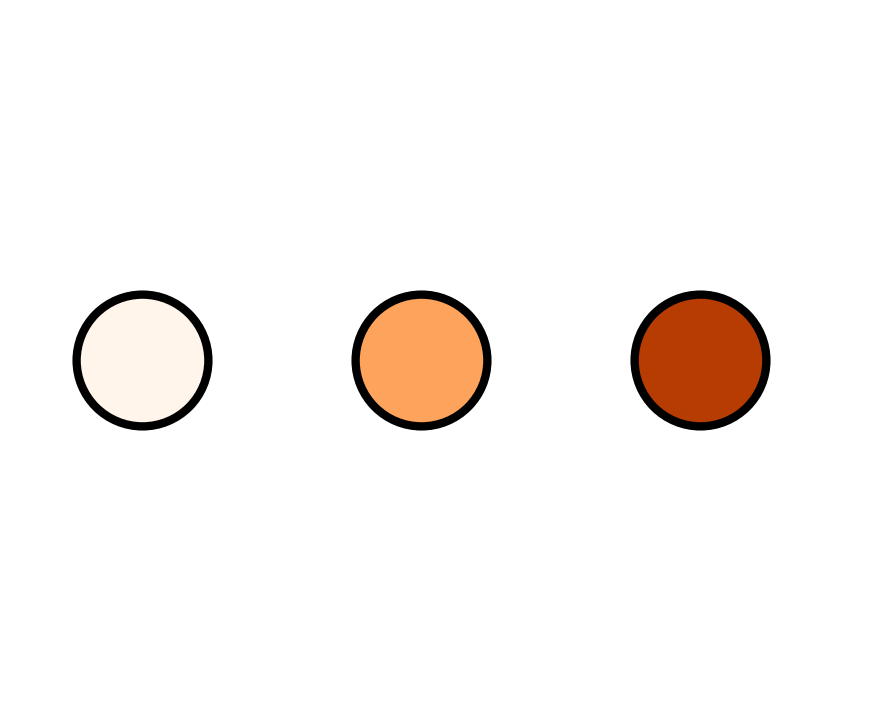

In [204]:
fig,ax = plt.subplots(1,1,figsize=(3,2.5))
timepoints_list = list(range(0,21,10))
vmin, vmax = 0, 24

ax.set_xlim(-4,25)
colormap_func = create_colormap_function(vmin, vmax,cmap_name="Oranges")
for timepoint in timepoints_list:
    timepoint_color = colormap_func(timepoint)
    ax.scatter(timepoint,0,edgecolors='black',alpha=1,s=1000,linewidth=2,c=timepoint_color)
sns.despine(right=True,top=True,left=True,bottom=True)
ax.set_axis_off()
plt.savefig(base_export_path + "/ValS_Time_Key.png",transparent=True,dpi=500,bbox_inches="tight")

## Figure 2F

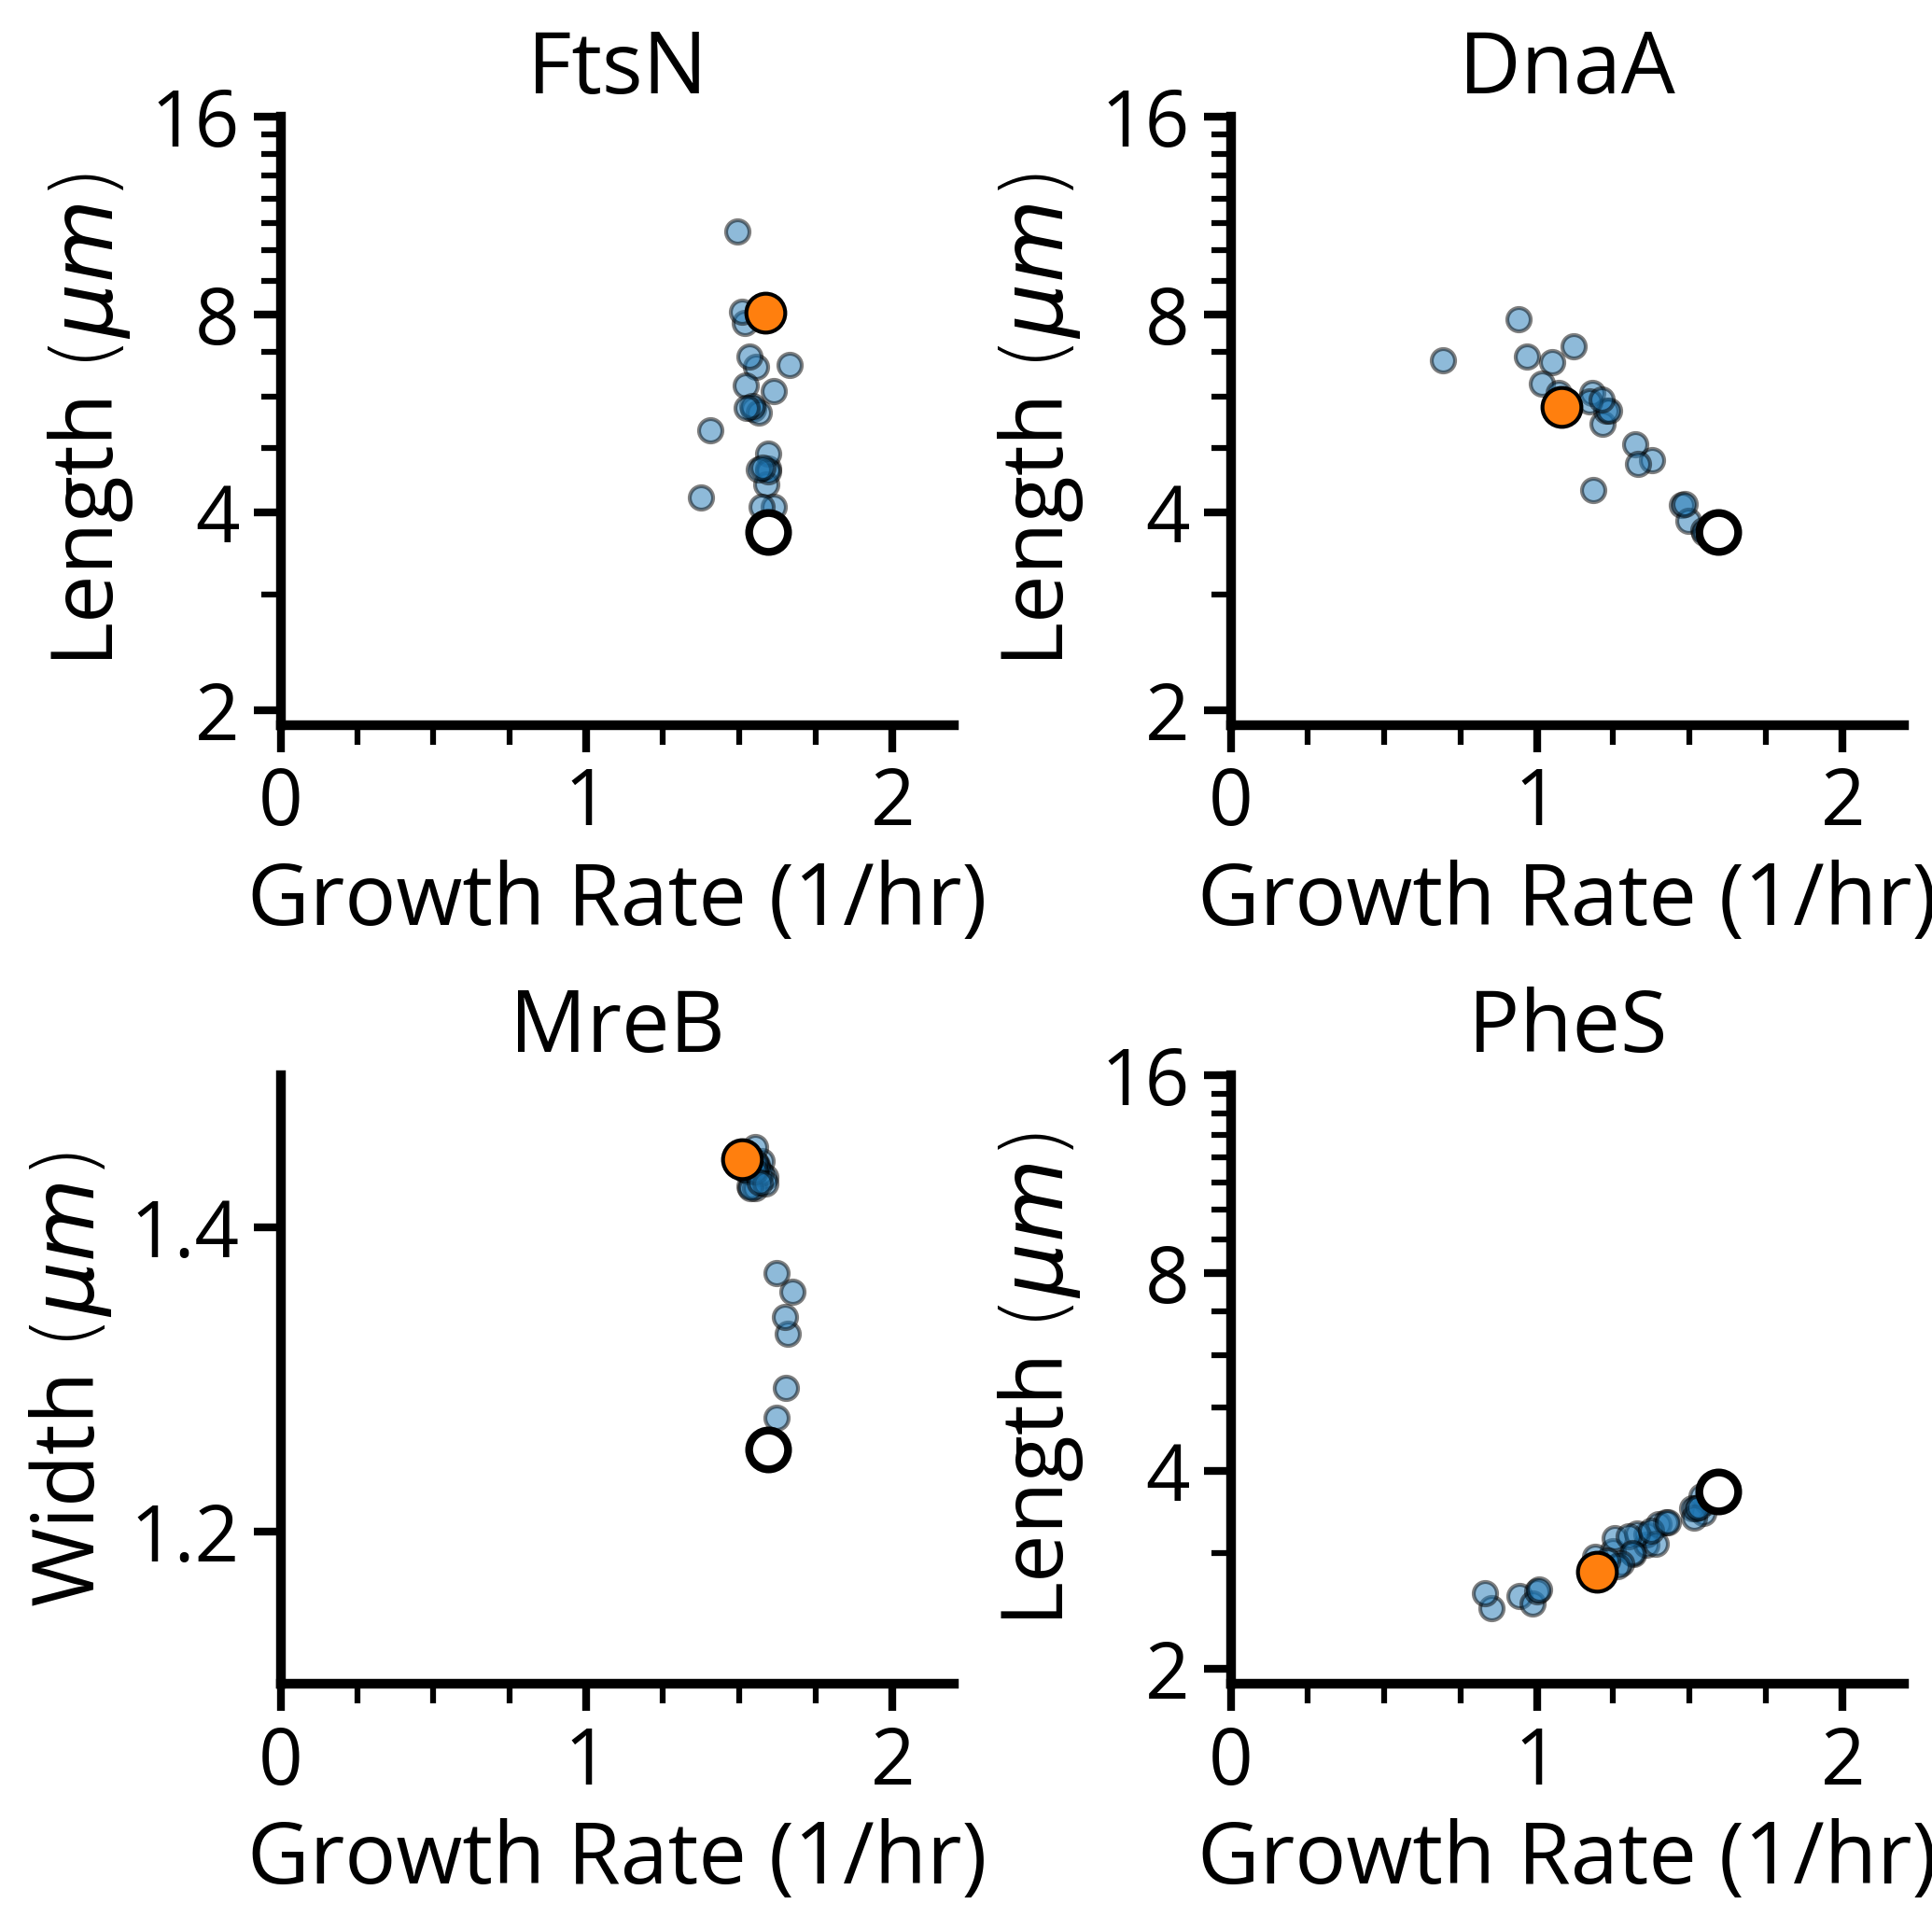

In [220]:
label_fontsize = 22
tick_fontsize = 20

fig = plt.figure(figsize=(7,7))

ax = plt.subplot(2,2,1)

ax.set_title("FtsN",fontsize=label_fontsize)
ax.scatter(ftsN_df["Instantaneous Growth Rate: Volume"],ftsN_df["Length"],edgecolors='black',alpha=0.5,zorder=-10)
ax.scatter(ftsN_df_lDE26_subset["Instantaneous Growth Rate: Volume"],ftsN_df_lDE26_subset["Length"],color="tab:Orange",\
           edgecolors='black',alpha=1,zorder=-9,s=100)
ax.scatter(wt_gr,wt_length,color="white",s=100,edgecolors='black',linewidth=2)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=label_fontsize)
ax.set_ylabel("Length $ (\mu m) $",fontsize=label_fontsize)
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,16)
ax.set_yscale("log")
ax.set_yticks(ticks=[2,4,8,16],labels=["2","4","8","16"],fontsize=tick_fontsize,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13,14,15],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=tick_fontsize,  width=2, length=7)
ax.tick_params(axis='both', direction='out', labelsize=tick_fontsize,  width=1.5, which='minor', length=5)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)

ax = plt.subplot(2,2,2)

ax.set_title("DnaA",fontsize=label_fontsize)
ax.scatter(dnaA_df["Instantaneous Growth Rate: Volume"],dnaA_df["Length"],edgecolors='black',alpha=0.5,zorder=-10)
ax.scatter(dnaA_df_lDE26_subset["Instantaneous Growth Rate: Volume"],dnaA_df_lDE26_subset["Length"],color="tab:Orange",\
           edgecolors='black',alpha=1,zorder=-9,s=100)
ax.scatter(wt_gr,wt_length,color="white",s=100,edgecolors='black',linewidth=2)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=label_fontsize)
ax.set_ylabel("Length $ (\mu m) $",fontsize=label_fontsize)
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,16)
ax.set_yscale("log")
ax.set_yticks(ticks=[2,4,8,16],labels=["2","4","8","16"],fontsize=tick_fontsize,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13,14,15],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=tick_fontsize,  width=2, length=7)
ax.tick_params(axis='both', direction='out', labelsize=tick_fontsize,  width=1.5, which='minor', length=5)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)

ax = plt.subplot(2,2,3)

ax.set_title("MreB",fontsize=label_fontsize)
ax.scatter(mreB_df["Instantaneous Growth Rate: Volume"],mreB_df["Width"],edgecolors='black',alpha=0.5,zorder=-10)
ax.scatter(mreB_df_lDE26_subset["Instantaneous Growth Rate: Volume"],mreB_df_lDE26_subset["Width"],color="tab:Orange",\
           edgecolors='black',alpha=1,zorder=-9,s=100)
ax.scatter(wt_gr,wt_width,color="white",s=100,edgecolors='black',linewidth=2)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=label_fontsize)
ax.set_ylabel("Width $ (\mu m) $",fontsize=label_fontsize)
ax.set_xlim(0,2.2)
ax.set_ylim(1.1,1.5)
# ax.set_yscale("log")
# ax.set_yticks(ticks=[2,4,8,16],labels=["2","4","8","16"],fontsize=16,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],fontsize=tick_fontsize,minor=False)
# ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13,14,15],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=tick_fontsize,  width=2, length=7)
ax.tick_params(axis='both', direction='out', labelsize=tick_fontsize,  width=1.5, which='minor', length=5)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)

ax = plt.subplot(2,2,4)

ax.set_title("PheS",fontsize=label_fontsize)
ax.scatter(pheS_df["Instantaneous Growth Rate: Volume"],pheS_df["Length"],edgecolors='black',alpha=0.5,zorder=-10)
ax.scatter(pheS_df_lDE26_subset["Instantaneous Growth Rate: Volume"],pheS_df_lDE26_subset["Length"],color="tab:Orange",\
           edgecolors='black',alpha=1,zorder=-9,s=100)
ax.scatter(wt_gr,wt_length,color="white",s=100,edgecolors='black',linewidth=2)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=label_fontsize)
ax.set_ylabel("Length $ (\mu m) $",fontsize=label_fontsize)
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,16)
ax.set_yscale("log")
ax.set_yticks(ticks=[2,4,8,16],labels=["2","4","8","16"],fontsize=tick_fontsize,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13,14,15],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=tick_fontsize,  width=2, length=7)
ax.tick_params(axis='both', direction='out', labelsize=tick_fontsize,  width=1.5, which='minor', length=5)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)

plt.tight_layout()
plt.savefig(base_export_path + "/Example_Titrations.png",transparent=True,dpi=500,bbox_inches="tight")

## Figure 2G

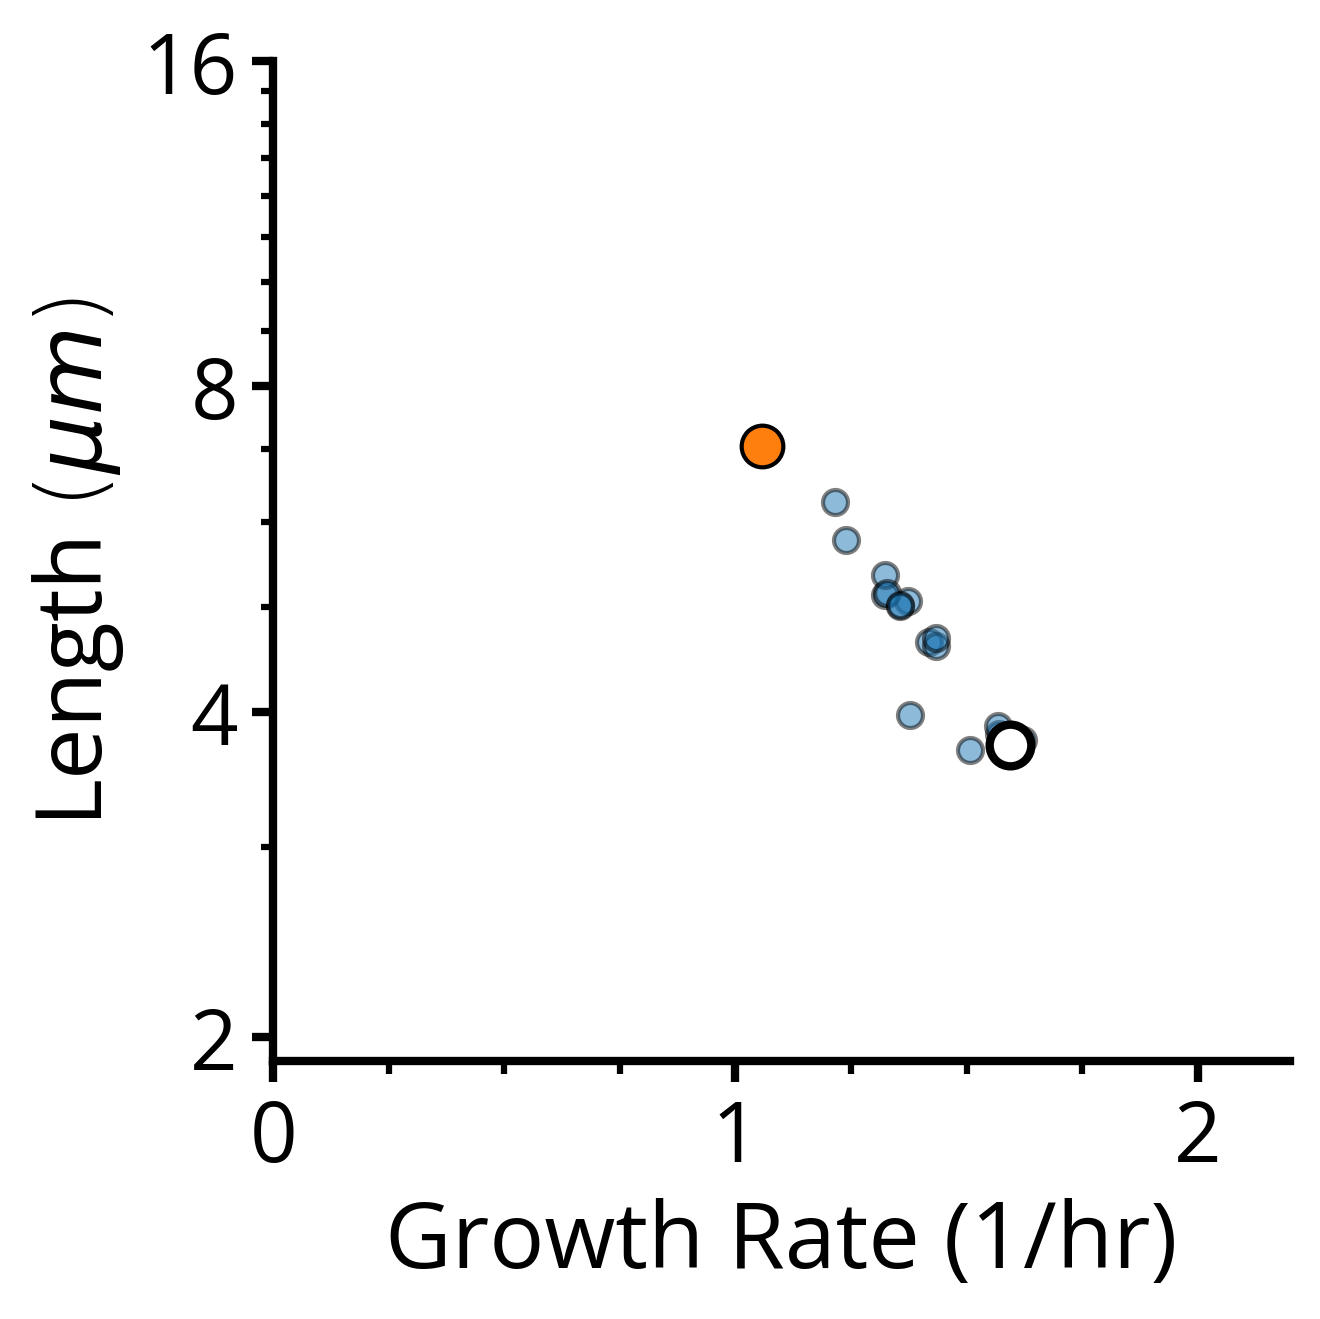

In [850]:
fig,ax = plt.subplots(1,1,figsize=(4.5,4.5))

ax.set_title("",fontsize=22)
ax.scatter(dnaB_df["Instantaneous Growth Rate: Volume"],dnaB_df["Length"],edgecolors='black',alpha=0.5,zorder=-10)
ax.scatter(dnaB_df_lDE26_subset["Instantaneous Growth Rate: Volume"],dnaB_df_lDE26_subset["Length"],color="tab:Orange",\
           edgecolors='black',alpha=1,zorder=-9,s=100)
ax.scatter(wt_gr,wt_length,color="white",s=100,edgecolors='black',linewidth=2)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=22)
ax.set_ylabel("Length $ (\mu m) $",fontsize=22)
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,16)
ax.set_yscale("log")
ax.set_yticks(ticks=[2,4,8,16],labels=["2","4","8","16"],fontsize=20,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13,14,15],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=20,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=20,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2)   # Set thickness of the left spine
sns.despine(right=True,top=True)

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_2/Strong_sgRNA_dnaB.png",transparent=True,dpi=500,bbox_inches="tight")

In [886]:
lDE26_ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Imaging/2024-02-10_lDE26_Steady_State_df_Estimators_wStats.pkl")
lDE26_design = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Sequencing/2023-02-03_Nucleoid_Screen_Design_V2.tsv",sep="\t")
lDE26_ss_estimators_df = lDE26_ss_estimators_df.loc["Mean (Robust)","Length"]

lDE26_ss_estimators_df = lDE26_ss_estimators_df.reset_index().set_index("oDEPool7_id")
n_obs_barcodes = lDE26_ss_estimators_df.groupby("oDEPool7_id",sort=False)["N Observations"].sum().astype(int)
lDE26_design_no_controls = lDE26_design[lDE26_design["Category"]=='Target']
n_obs_barcodes_df = lDE26_design_no_controls[["oDEPool7_id","Gene"]].set_index("oDEPool7_id")
n_obs_barcodes_df["N Observations"] = n_obs_barcodes
n_obs_genes = n_obs_barcodes_df.groupby("Gene",sort=False)["N Observations"].sum().astype(int)

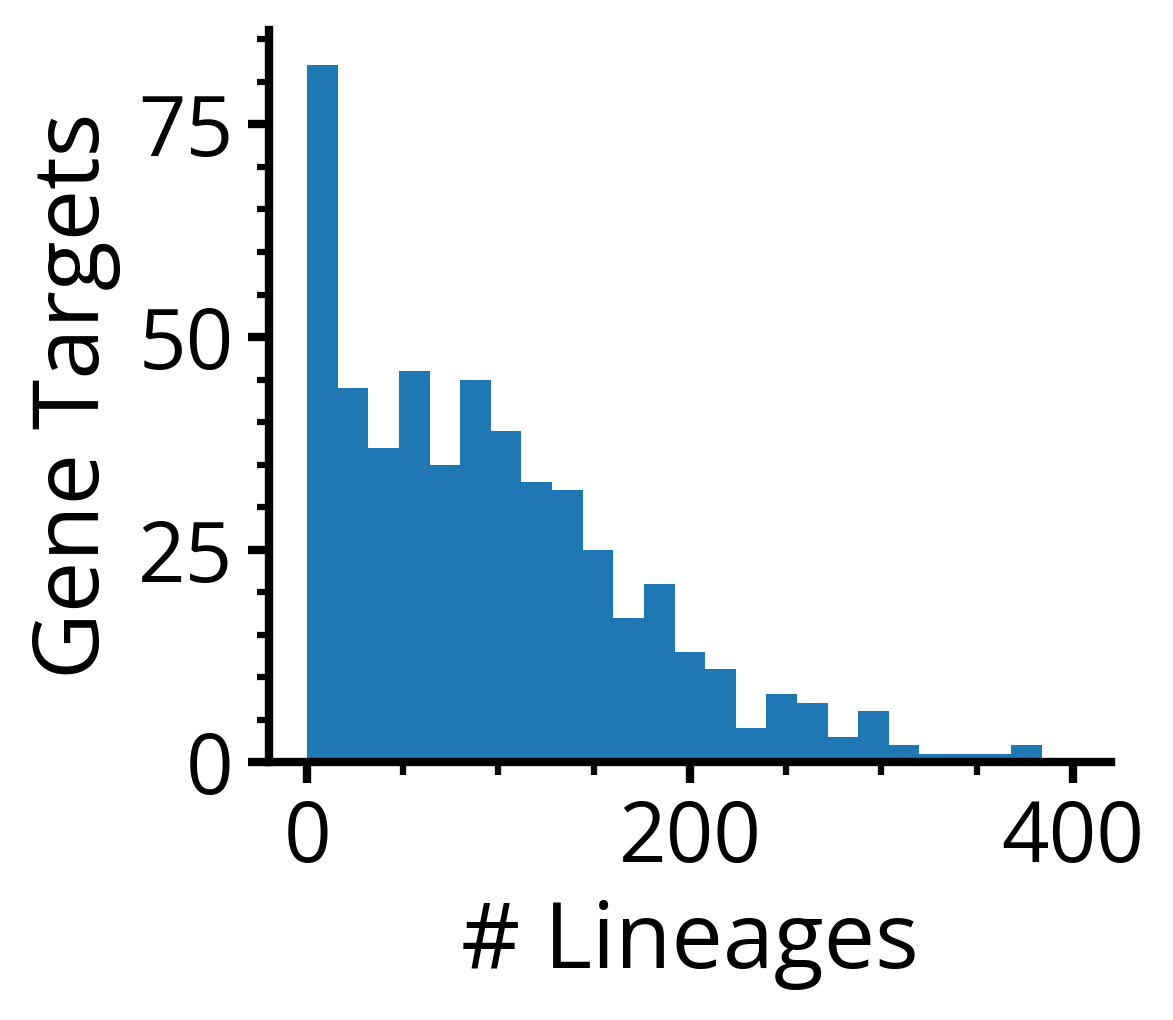

In [887]:
plt.figure(figsize=(4,3.5))
ax = plt.subplot(1,1,1)
ax.minorticks_on()
ax.set_xlabel("# Lineages",fontsize=22)
ax.set_ylabel("Gene Targets",fontsize=22)
ax.tick_params(axis='both', direction='out', labelsize=20,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=20,  width=1.5, which='minor', length=3)
ax.hist(n_obs_genes,range=(0,400),bins=25)
ax.spines['bottom'].set_linewidth(2) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2)   # Set thickness of the left spine
sns.despine()

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_2/lDE26_Variant_Coverage.png",transparent=True,dpi=500,bbox_inches="tight")

## Figure 2H

In [791]:
### setup for nucleoid experiment
headpath = "/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/Growth_Division/"

kymo_df = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/Growth_Division/kymograph/metadata",calculate_divisions=True)
kymo_df = kymo_df.get_partition(0).compute()
kymo_df = kymo_df.reset_index().groupby("trench").first()

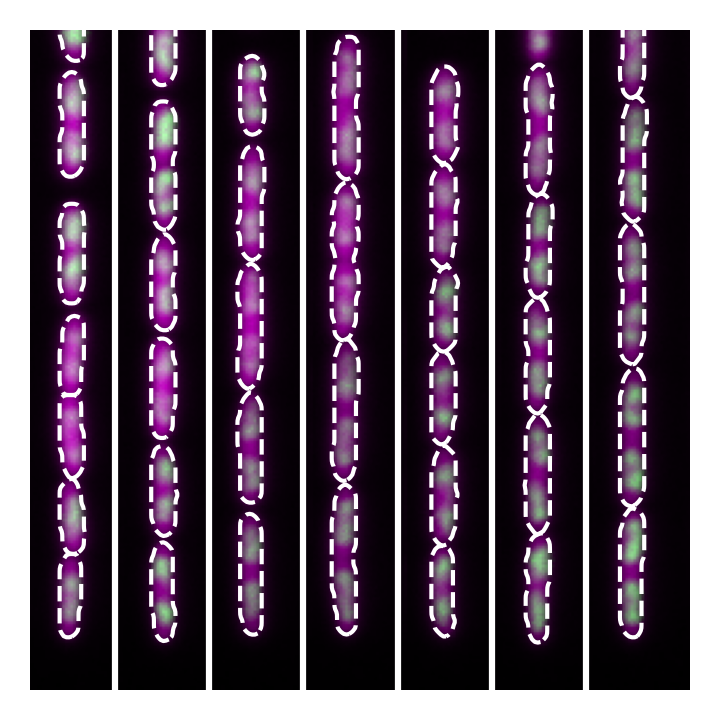

In [809]:
# fetch trenches
idx = 28
t_step = 1
# t_step = 1
t_i = 4
t_f = 11
# t_i = 36
cropx = 1

min_intensity_green = 3000
max_intensity_green = 15000
min_intensity_magenta = 0
max_intensity_magenta = 50000

magenta_weight = 0.8
green_weight = 1

scalebar_on = False
output_path = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_2"

# selected_trench = barcode_df.iloc[idx]
selected_trench = kymo_df.iloc[idx]

file_idx,trench_idx,orient = selected_trench['File Index'],selected_trench['File Trench Index'],\
    selected_trench["lane orientation"]

with h5py.File(headpath + "/kymograph/kymograph_" +\
               str(file_idx) + ".hdf5", "r") as infile:
    nuc_data = infile["mCherry"][trench_idx,t_i:t_f:t_step,:,cropx:-cropx]
    cyto_data = infile["YFP"][trench_idx,t_i:t_f:t_step,:,cropx:-cropx]
with h5py.File(headpath + "/fluorsegmentation/segmentation_" +\
               str(file_idx) + ".hdf5", "r") as infile:
    seg_data = infile["data"][trench_idx,t_i:t_f:t_step,:,cropx:-cropx]
with h5py.File(headpath + "/nucleoidsegmentation/segmentation_" +\
               str(file_idx) + ".hdf5", "r") as infile:
    nuc_seg_data = infile["data"][trench_idx,t_i:t_f:t_step,:,cropx:-cropx]

if orient == "top":
    nuc_data = nuc_data[:,::-1]
    cyto_data = cyto_data[:,::-1]
    seg_data = seg_data[:,::-1]
    nuc_seg_data = nuc_seg_data[::-1]

nuc_seg_output = []
for t in range(nuc_seg_data.shape[0]):
    working_seg_data = nuc_seg_data[t]
    working_seg_data[working_seg_data>0] = working_seg_data[working_seg_data>0]+(100*t)
    nuc_seg_output.append(working_seg_data)
    
nuc_seg_output = np.concatenate(nuc_seg_output,axis=1)
nuc_seg_output, _, _ = sk.segmentation.relabel_sequential(nuc_seg_output)

nuc_seg_borders_list = []
for i in range(1,np.max(nuc_seg_output)+1):
    nuc_seg_borders = sk.measure.find_contours(sk.filters.gaussian(nuc_seg_output == i,sigma=0.5), level=0.5)[0]
    nuc_seg_borders_list.append(nuc_seg_borders)

tr.plot_kymograph_2channel(nuc_data,cyto_data,min_intensity_green,max_intensity_green,\
                       min_intensity_magenta,max_intensity_magenta,channel_1_weight=green_weight,\
                           channel_2_weight=magenta_weight,seg_kymo=seg_data,seg_sigma=1,seg_thickness=1)
# for i,nuc_seg_border in enumerate(nuc_seg_borders_list):
#     plt.plot(nuc_seg_border[:,1],nuc_seg_border[:,0],color="black",linestyle="--",linewidth=1.5)
plt.ylim(280,35)
# Add a label next to the scale bar
if scalebar_on:
    # Draw the scale bar
    plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
            [scalebar_y_position, scalebar_y_position],
            color=scalebar_color,
            linewidth=6)
    plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
            scalebar_y_position+5,
            f'{scale_bar_size_um} $\mu m$',
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=25)
plt.vlines([(seg_data.shape[2]*t)-4 for t in range(1,seg_data.shape[0])],0,seg_data.shape[1],linestyle="-",color="white",linewidth=1.5,zorder=20)
plt.axis('off')
plt.savefig(output_path + "/nuc_kymo_" + str(idx) + ".png",transparent=True,dpi=500,bbox_inches="tight")

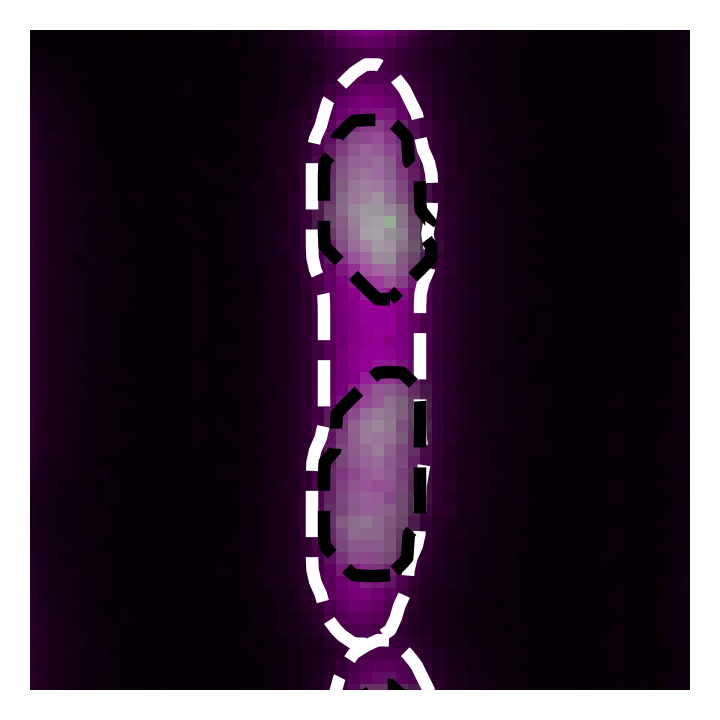

In [810]:
tr.plot_kymograph_2channel(nuc_data,cyto_data,min_intensity_green,max_intensity_green,\
                       min_intensity_magenta,max_intensity_magenta,channel_1_weight=green_weight,\
                           channel_2_weight=magenta_weight,seg_kymo=seg_data,seg_sigma=1,seg_thickness=3)
for i,nuc_seg_border in enumerate(nuc_seg_borders_list):
    plt.plot(nuc_seg_border[:,1],nuc_seg_border[:,0],color="black",linestyle="--",linewidth=3)
plt.ylim(100,45)
plt.xlim(160,215)

plt.axis('off')
plt.savefig(output_path + "/nuc_kymo_" + str(idx) + "_zoom_1.png",transparent=True,dpi=500,bbox_inches="tight")

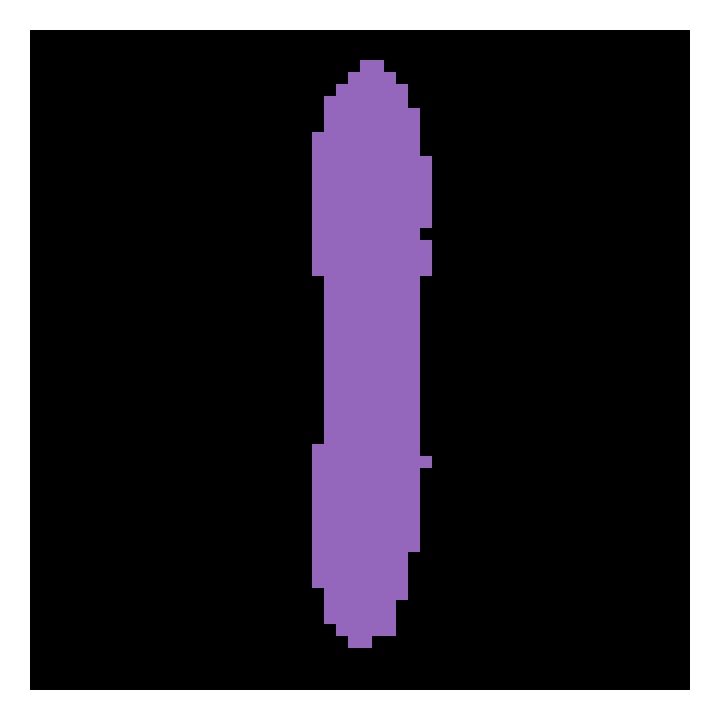

In [825]:
# Define the colors for the gradient: 'tab:magenta' to 'black'
# Matplotlib's 'tab:magenta' RGB values can be found in its documentation or source code. Here's an approximation:
tab_magenta_rgb = mcolors.to_rgb('tab:purple')  # This gets the RGB values for 'tab:magenta'
tab_green_rgb = mcolors.to_rgb('tab:green')
black_rgb = (0, 0, 0)  # RGB for black

# Create a colormap from tab:magenta to black
n_bins = 256  # Number of bins or levels in the gradient
purple_cmap = LinearSegmentedColormap.from_list("custom_purple", [black_rgb,tab_magenta_rgb], N=n_bins)
green_cmap = LinearSegmentedColormap.from_list("custom_green", [black_rgb,tab_green_rgb], N=n_bins)

tr.plot_kymograph(seg_data==1001,cmap=purple_cmap)

plt.ylim(100,45)
plt.xlim(160,215)

plt.axis('off')
plt.savefig(output_path + "/nuc_kymo_" + str(idx) + "_zoom_1_cyto.png",transparent=True,dpi=500,bbox_inches="tight")

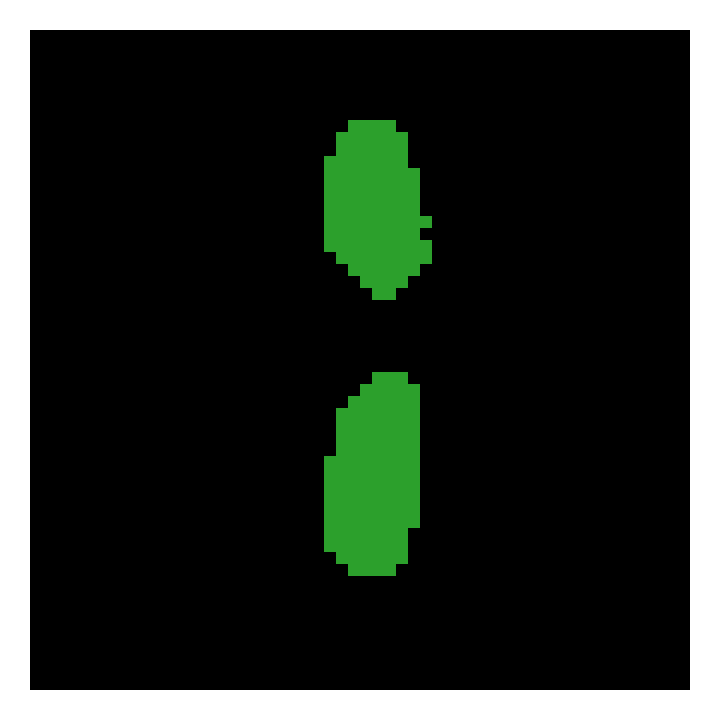

In [828]:
tr.plot_kymograph((nuc_seg_data==501)|(nuc_seg_data==502),cmap=green_cmap)

plt.ylim(100,45)
plt.xlim(160,215)
# 
plt.axis('off')
plt.savefig(output_path + "/nuc_kymo_" + str(idx) + "_zoom_1_nuc.png",transparent=True,dpi=500,bbox_inches="tight")

### Nucleoid Parameter Distributions

In [5]:
snapshot_sampling_frac = 0.01
snapshot_pheno_df = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/2023-04-21_lDE26_Run_1_Lineage_Observations",calculate_divisions=True)
snapshot_pheno_df = snapshot_pheno_df.sample(frac=snapshot_sampling_frac).compute()
snapshot_pheno_df = snapshot_pheno_df[snapshot_pheno_df["Observation time (s)"]<7200]

In [6]:
snapshot_pheno_labels = ["Number of Nucleoids"]
title_list = ["Number of Nucleoids"]
pheno_range = [(0,4.5)]
pheno_ticks = [[0,1,2,3,4]]
kde_density = [250]

output_path = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_2"

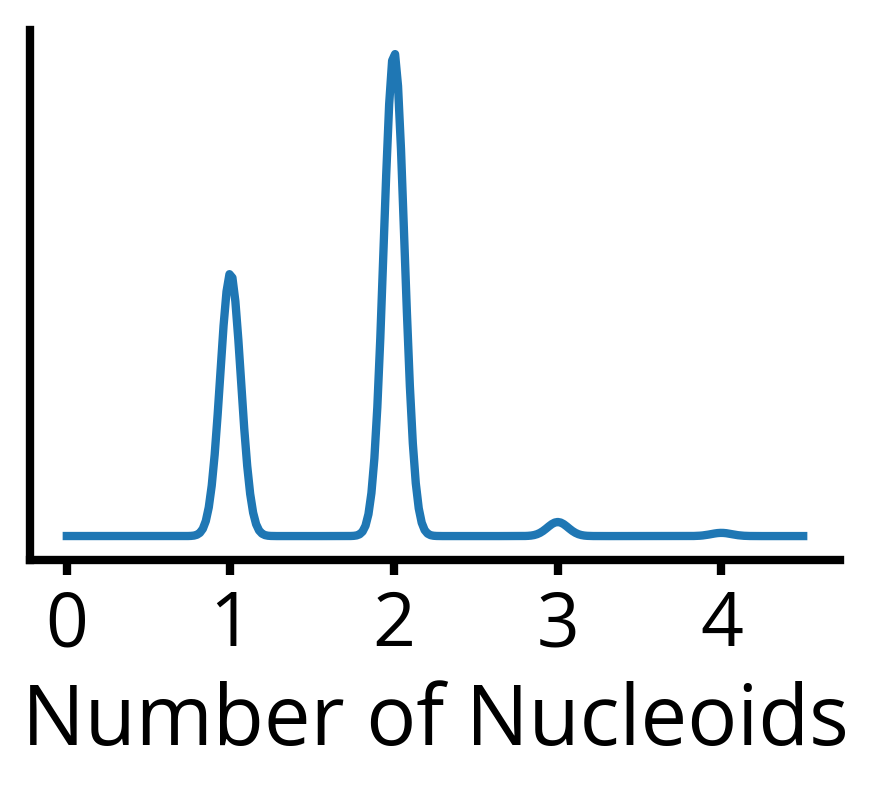

In [7]:
fig = plt.figure(figsize=(3,2.75))
for pheno_i in range(len(title_list)):
    ax = plt.subplot(1,1,pheno_i+1)
    
    pheno_domain = np.linspace(pheno_range[pheno_i][0],pheno_range[pheno_i][1],num=kde_density[pheno_i])
    ax.plot(pheno_domain,gaussian_kde(snapshot_pheno_df[snapshot_pheno_labels[pheno_i]])(pheno_domain),linewidth=2)
    ax.set_yticks([],labels=[])
    # plt.yticks([4,5,7,8,9,10,11],labels=[],minor=True)
    # plt.ylim(2.2,12)
    ax.set_xlabel(title_list[pheno_i],fontsize=20)
    ax.set_xticks(pheno_ticks[pheno_i])
    
    ax.spines['bottom'].set_linewidth(2) # Set thickness of the bottom spine
    ax.spines['left'].set_linewidth(2)   # Set thickness of the left spine
    ax.tick_params(axis='both', which='major', width=2, labelsize=18)  # Set major tick width
    sns.despine()
plt.tight_layout()
plt.savefig(output_path + "/nuc_parameter_distributions.png",transparent=True,dpi=500,bbox_inches="tight")

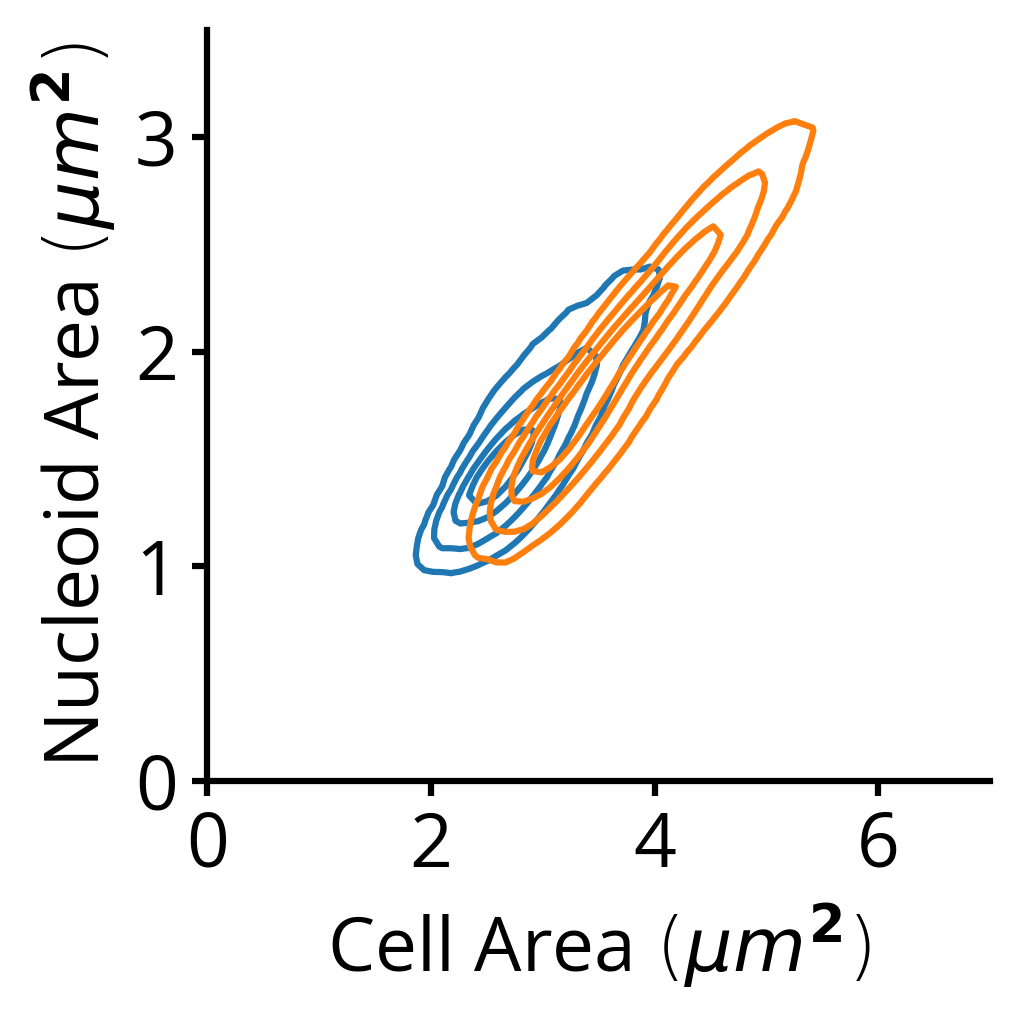

In [74]:
# Assuming snapshot_pheno_df is a DataFrame
x = snapshot_pheno_df["area"]
y = snapshot_pheno_df["Total Nucleoid Area"]
n_nuc = snapshot_pheno_df["Number of Nucleoids"]

n_nuc_dict = {0: "grey", 1: "tab:blue", 2: "tab:orange", 3: "tab:green", 4: "grey", 5: "grey", 6: "grey", 7: "grey"}
contour_percentiles = [0.10, 0.25, 0.50, 0.75]
xticks = [0,2,4,6]
yticks = [0,1,2,3]
colors = n_nuc.map(n_nuc_dict)

fig = plt.figure(figsize=(3.5, 3.5))
ax = plt.subplot(1,1,1)
plt.ylim(0, 3.5)
plt.xlim(0, 7)

for n in [1,2]:
    x_filtered,y_filtered = x[n_nuc==n],y[n_nuc==n]
    # Perform 2D density estimation
    data = np.vstack([x_filtered, y_filtered])
    kde = gaussian_kde(data, bw_method='scott')
    
    # Create a grid for the density plot
    x_grid, y_grid = np.meshgrid(np.linspace(0, 8, 100), np.linspace(0, 4, 100))
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    density = kde(positions).reshape(x_grid.shape)
    # Normalize the density to probabilities
    density_flat = density.ravel()
    sorted_density = np.sort(density_flat)
    cumulative = np.cumsum(sorted_density)
    cumulative /= cumulative[-1]  # Normalize to 1
    # Determine levels corresponding to cumulative probabilities
    density_levels = np.interp(contour_percentiles, cumulative, sorted_density)
    
    # Plot the density as a contour plot
    plt.contour(x_grid, y_grid, density, colors=n_nuc_dict[n],levels=density_levels,linewidths=1.5)
ax.spines['bottom'].set_linewidth(1.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(1.5)   # Set thickness of the left spine
ax.tick_params(axis='both', which='major', width=1.5, labelsize=18)  # Set major tick width
plt.xlabel("Cell Area $ (\mu m^{\mathbf{2}}) $", fontsize=18)
plt.ylabel("Nucleoid Area $ (\mu m^{\mathbf{2}}) $", fontsize=18)
plt.xticks(xticks)
plt.yticks(yticks)
sns.despine()
plt.tight_layout()
plt.savefig(output_path + "/bivar_nuc_parameter_distributions.png",transparent=True,dpi=500,bbox_inches="tight")

In [ ]:
dask_controller.shutdown()